<a href="https://colab.research.google.com/github/Narcissist1/Cellari-Deeplearning-Course/blob/codelab/CellariTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import glob
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from segnet import SegNet
from unet import UNet
from torch.optim import lr_scheduler

In [0]:
use_cuda = torch.cuda.is_available()

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

In [42]:
if use_cuda:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
if use_cuda:
    path_to_images = '/content/drive/My Drive/train/raw_images'
    path_to_annotations = '/content/drive/My Drive/train/annotations_white'
else:
    path_to_images = 'train/raw_images'
    path_to_annotations = 'train/annotations_white'

transform_pipe = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Convert np array to PILImage
    
    torchvision.transforms.RandomCrop(size=(128, 128)),
    
    torchvision.transforms.RandomHorizontalFlip(0.5),
    
    torchvision.transforms.RandomVerticalFlip(0.5),
    
    torchvision.transforms.ToTensor()
])

transform_observe = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Convert np array to PILImage
    torchvision.transforms.ToTensor()
])


# Unet resize transform
transform_resize = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Convert np array to PILImage
    
    torchvision.transforms.Resize((212, 212)),
    
    torchvision.transforms.ToTensor()
])

data_norm = torchvision.transforms.Normalize(mean=[0.78092086, 0.5018261, 0.7803567],
                                 std=[0.16727196, 0.24176046, 0.13103652])
# anno_norm =  torchvision.transforms.Normalize(mean=[0.00202586], std=[0.00176733])


class CustomDataset(Dataset):
    
    def __init__(self, img_list, anno_list, num_of_classes=2, transform=None):
        
        self.img_list = img_list
        self.anno_list = anno_list
        self.num_of_classes = num_of_classes
        self.transform = transform
        
    def __getitem__(self, img_id):
        
        image = Image.open(img_list[img_id])
        img = np.array(image)
        anno = np.array(Image.open(self.anno_list[img_id]).convert("L"))

        seed = np.random.randint(2147483647)
        random.seed(seed)
        if self.transform:
            img = self.transform(img)
            img = data_norm(img)
            random.seed(seed)
            anno = self.transform(anno)
            # anno = transform_resize(anno)     # unet resize

        anno[anno>0] = 1
        # anno_reshaped = np.zeros((self.num_of_classes, anno.shape[1], anno.shape[2]))
        # for i in range(self.num_of_classes):
        #     anno_reshaped[i, :, :][anno[0] == i] = 1

        sample = {"image": img, "annotation": anno}
        return sample
    
    
    def __len__(self):
        return len(self.img_list)

img_list = glob.glob(path_to_images + os.sep + "*.bmp")
img_list = sorted(img_list)
anno_list = glob.glob(path_to_annotations + os.sep + "*.bmp")
anno_list = sorted(anno_list)
dataset_train = CustomDataset(img_list, anno_list, 2, transform=transform_pipe)
dataset_observe = CustomDataset(img_list, anno_list, 2, transform=transform_observe)

In [0]:
dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size = 50,
    shuffle=True
)

dataloader_observe = torch.utils.data.DataLoader(
    dataset_observe,
    batch_size = 1,
    shuffle=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(50, 3, 128, 128)


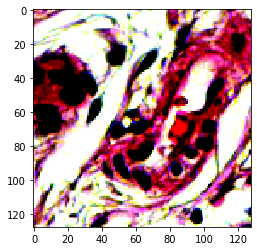

torch.Size([50, 1, 128, 128])


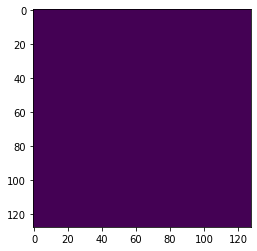

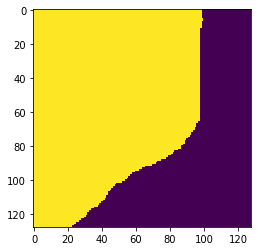

In [45]:
data = [batch_data for batch_data in dataloader_train]
batch_data = data[0]
fig_img = plt.figure()
print(batch_data['image'].numpy().shape)
plt.imshow(batch_data['image'][0].permute(1, 2, 0).numpy())
plt.show()
print(batch_data['annotation'].shape)
batch_data['annotation'] = batch_data['annotation']
plt.imshow(batch_data['annotation'][0][0])
fig_img.suptitle('image')
plt.show()
plt.imshow(batch_data['annotation'][1][0])
plt.show()

In [0]:
net = SegNet(1, n_init_features=3) # input channels, output channels
# net = UNet(1, n_init_features=3)
if use_cuda:
    net.cuda()

In [0]:
LEARNING_RATE = 0.001
criterion = nn.BCEWithLogitsLoss() 

# optimizer = optim.SGD(net.parameters(), LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), 5e-5, (0.9, 0.999),  eps=1e-08, weight_decay=1e-2)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[200], gamma=0.1)


train loss:  0.6975950598716736


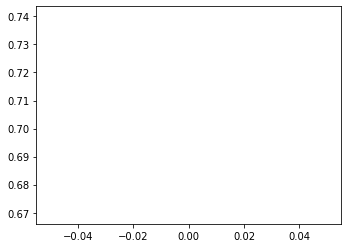

Train, it: 0 loss: 0.70
train loss:  0.6886276006698608


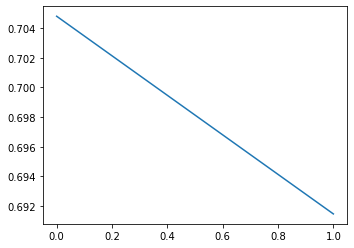

Train, it: 1 loss: 0.69
train loss:  0.6920477747917175


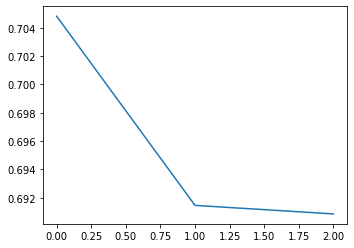

Train, it: 2 loss: 0.69
train loss:  0.7001031041145325


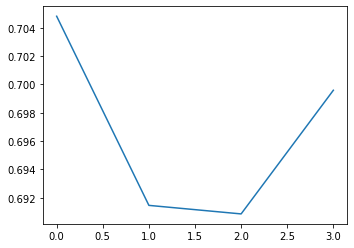

Train, it: 3 loss: 0.70
train loss:  0.679448127746582


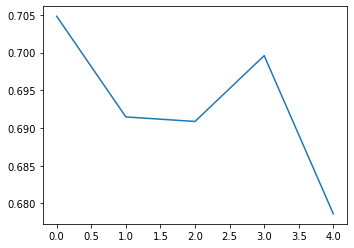

Train, it: 4 loss: 0.68
train loss:  0.7101649045944214


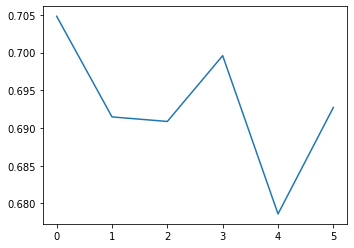

Train, it: 5 loss: 0.69
train loss:  0.6719305515289307


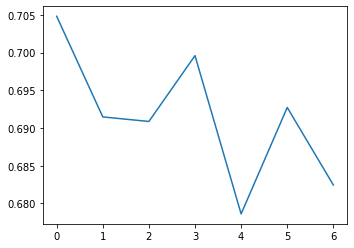

Train, it: 6 loss: 0.68
train loss:  0.6675706505775452


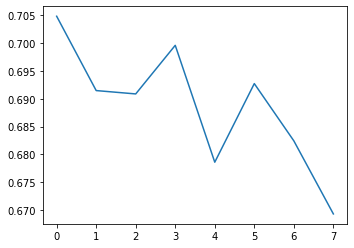

Train, it: 7 loss: 0.67
train loss:  0.6630767583847046


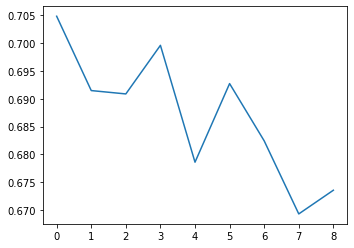

Train, it: 8 loss: 0.67
train loss:  0.6331198811531067


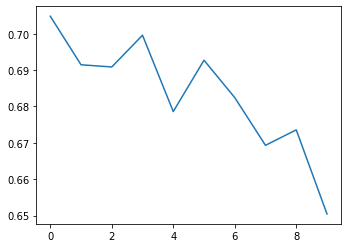

Train, it: 9 loss: 0.65
train loss:  0.6548985838890076


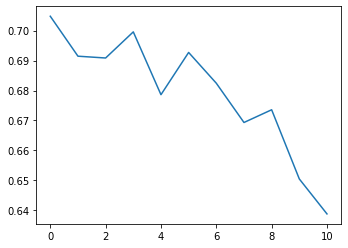

Train, it: 10 loss: 0.64
train loss:  0.6593435406684875


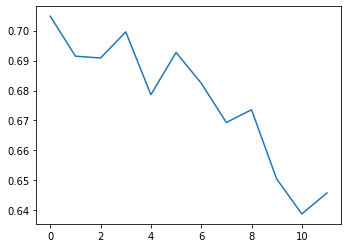

Train, it: 11 loss: 0.65
train loss:  0.6520806550979614


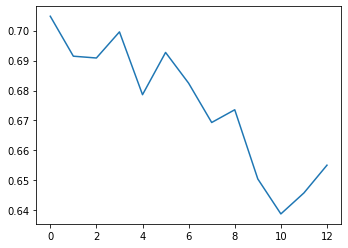

Train, it: 12 loss: 0.66
train loss:  0.6388722062110901


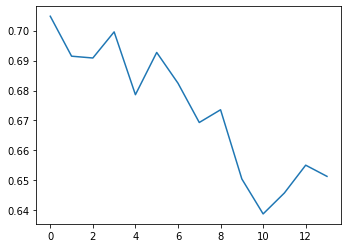

Train, it: 13 loss: 0.65
train loss:  0.6411367654800415


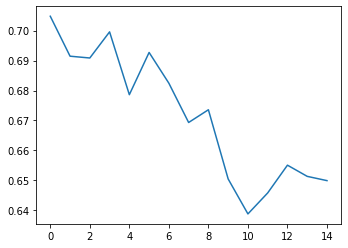

Train, it: 14 loss: 0.65
train loss:  0.6283263564109802


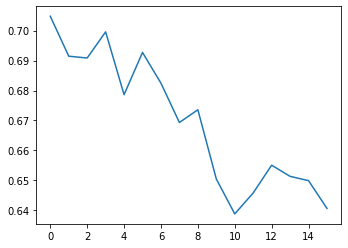

Train, it: 15 loss: 0.64
train loss:  0.6470266580581665


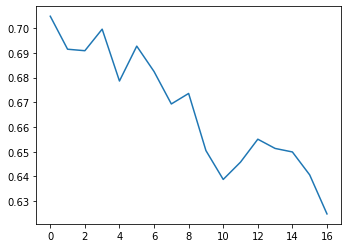

Train, it: 16 loss: 0.62
train loss:  0.6296147704124451


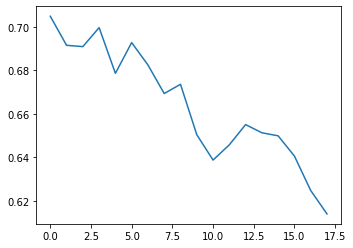

Train, it: 17 loss: 0.61
train loss:  0.6092283725738525


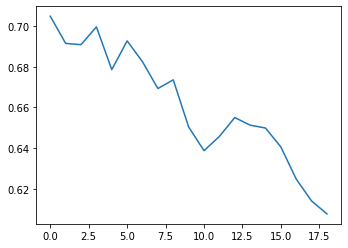

Train, it: 18 loss: 0.61
train loss:  0.5908348560333252


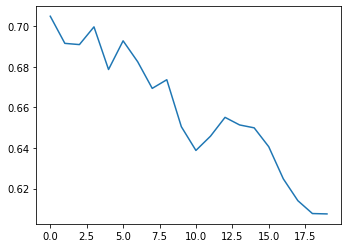

Train, it: 19 loss: 0.61
train loss:  0.5817512273788452


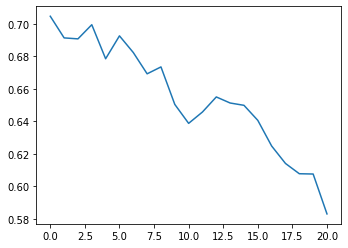

Train, it: 20 loss: 0.58
train loss:  0.6105378270149231


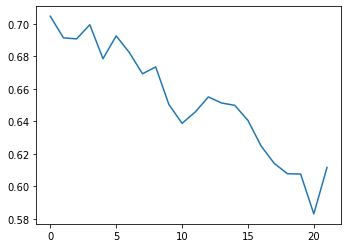

Train, it: 21 loss: 0.61
train loss:  0.5857875943183899


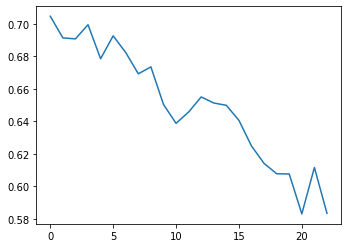

Train, it: 22 loss: 0.58
train loss:  0.5781543850898743


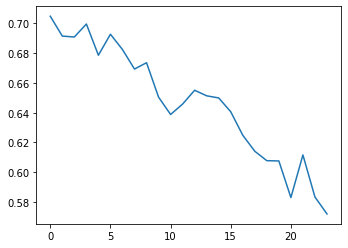

Train, it: 23 loss: 0.57
train loss:  0.6569163203239441


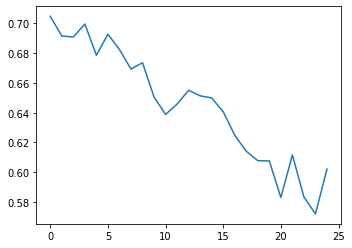

Train, it: 24 loss: 0.60
train loss:  0.538515031337738


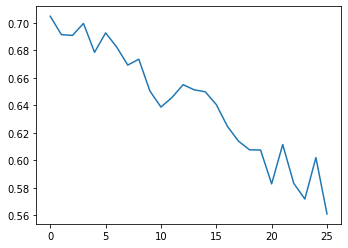

Train, it: 25 loss: 0.56
train loss:  0.5608701705932617


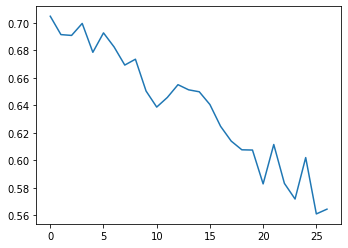

Train, it: 26 loss: 0.56
train loss:  0.5607590675354004


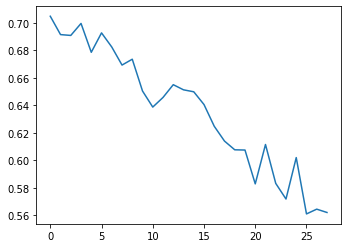

Train, it: 27 loss: 0.56
train loss:  0.5588926076889038


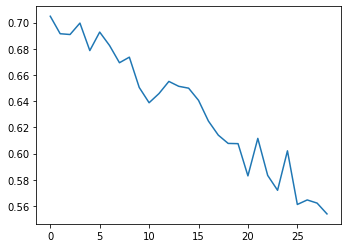

Train, it: 28 loss: 0.55
train loss:  0.5476623773574829


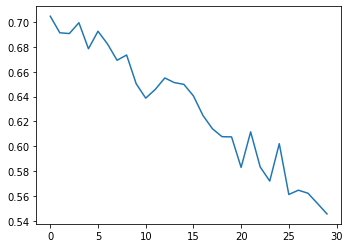

Train, it: 29 loss: 0.55
train loss:  0.5721476078033447


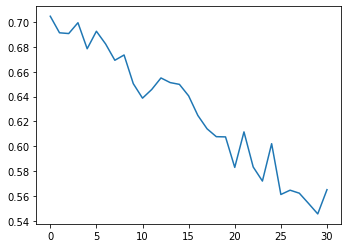

Train, it: 30 loss: 0.57
train loss:  0.531316339969635


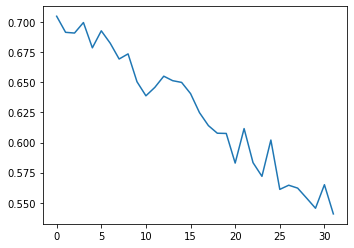

Train, it: 31 loss: 0.54
train loss:  0.5399309992790222


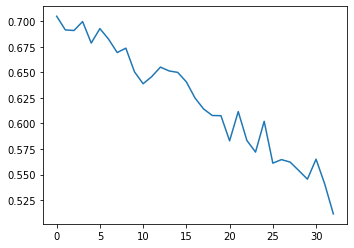

Train, it: 32 loss: 0.51
train loss:  0.5630583167076111


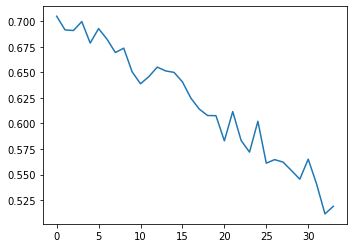

Train, it: 33 loss: 0.52
train loss:  0.529805064201355


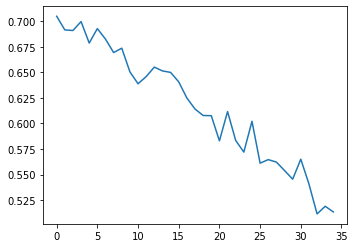

Train, it: 34 loss: 0.51
train loss:  0.525234580039978


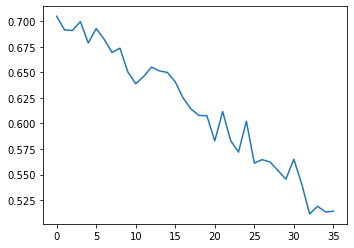

Train, it: 35 loss: 0.51
train loss:  0.569585919380188


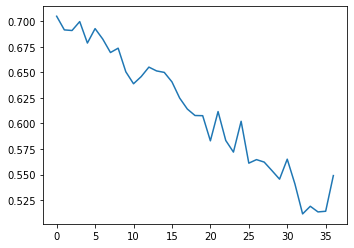

Train, it: 36 loss: 0.55
train loss:  0.4628894627094269


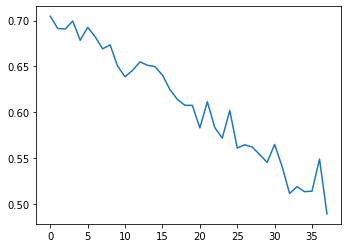

Train, it: 37 loss: 0.49
train loss:  0.4917536675930023


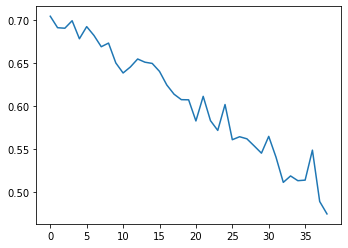

Train, it: 38 loss: 0.47
train loss:  0.46501240134239197


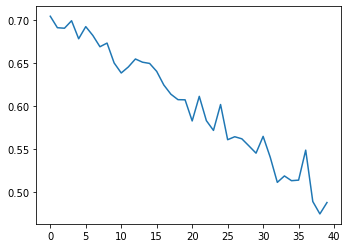

Train, it: 39 loss: 0.49
train loss:  0.44464758038520813


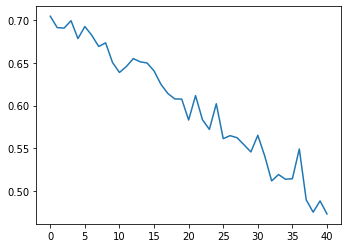

Train, it: 40 loss: 0.47
train loss:  0.44826263189315796


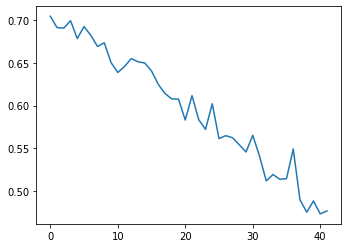

Train, it: 41 loss: 0.48
train loss:  0.49190062284469604


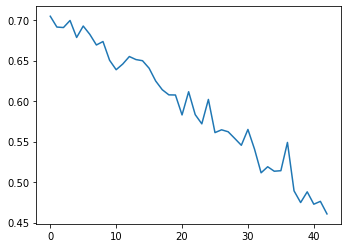

Train, it: 42 loss: 0.46
train loss:  0.48201173543930054


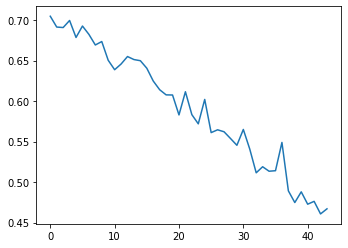

Train, it: 43 loss: 0.47
train loss:  0.4782828390598297


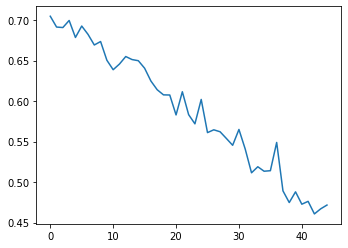

Train, it: 44 loss: 0.47
train loss:  0.52837073802948


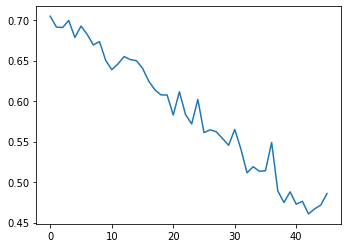

Train, it: 45 loss: 0.49
train loss:  0.3862665593624115


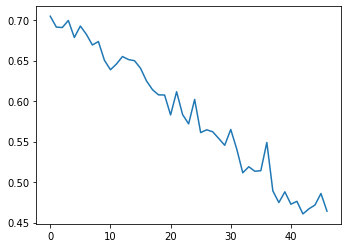

Train, it: 46 loss: 0.46
train loss:  0.4948674142360687


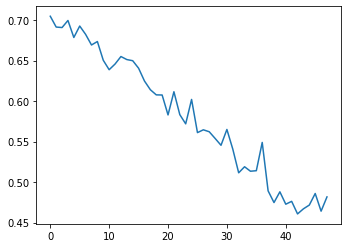

Train, it: 47 loss: 0.48
train loss:  0.49899229407310486


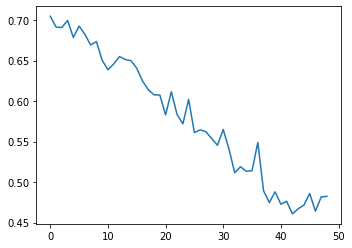

Train, it: 48 loss: 0.48
train loss:  0.480501651763916


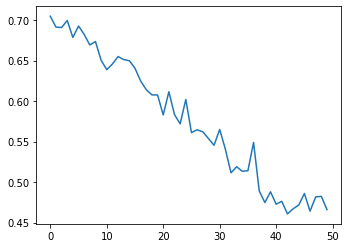

Train, it: 49 loss: 0.47
train loss:  0.513366162776947


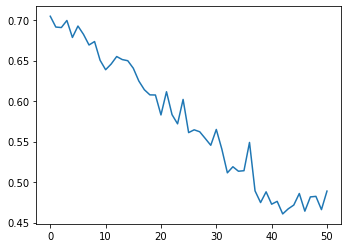

Train, it: 50 loss: 0.49
train loss:  0.4690837860107422


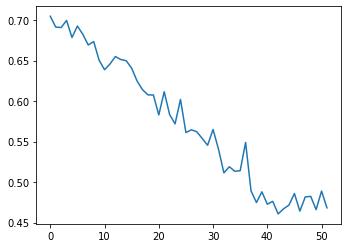

Train, it: 51 loss: 0.47
train loss:  0.5007768869400024


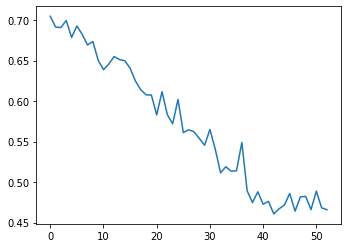

Train, it: 52 loss: 0.47
train loss:  0.5004655718803406


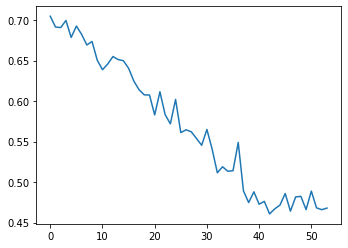

Train, it: 53 loss: 0.47
train loss:  0.42154592275619507


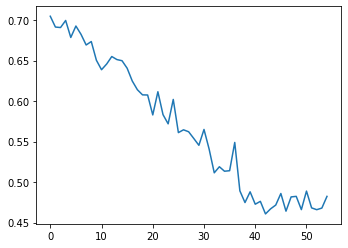

Train, it: 54 loss: 0.48
train loss:  0.4519174098968506


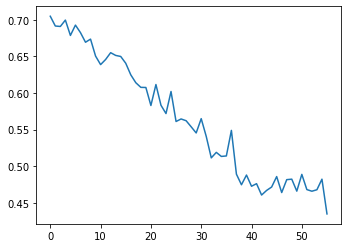

Train, it: 55 loss: 0.43
train loss:  0.42658451199531555


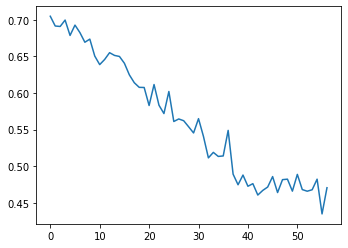

Train, it: 56 loss: 0.47
train loss:  0.4417547583580017


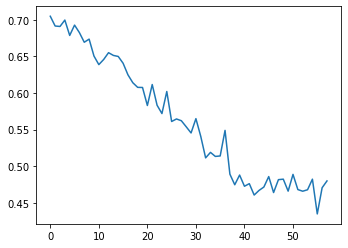

Train, it: 57 loss: 0.48
train loss:  0.4592682421207428


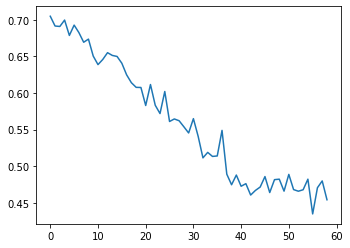

Train, it: 58 loss: 0.45
train loss:  0.4098605215549469


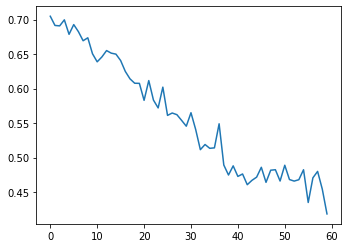

Train, it: 59 loss: 0.42
train loss:  0.4449804723262787


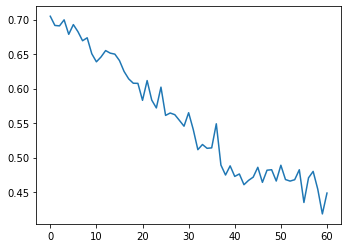

Train, it: 60 loss: 0.45
train loss:  0.4213451147079468


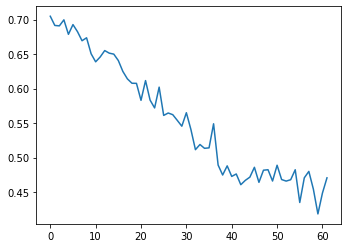

Train, it: 61 loss: 0.47
train loss:  0.39524996280670166


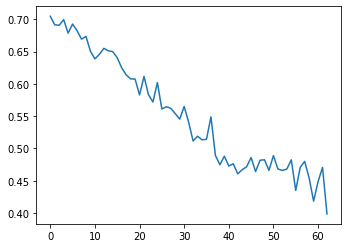

Train, it: 62 loss: 0.40
train loss:  0.3826013505458832


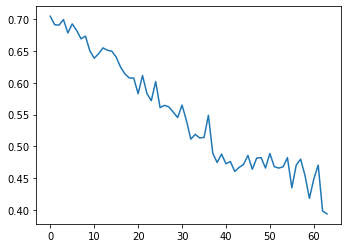

Train, it: 63 loss: 0.39
train loss:  0.437008261680603


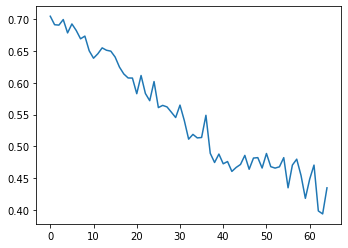

Train, it: 64 loss: 0.43
train loss:  0.3581264317035675


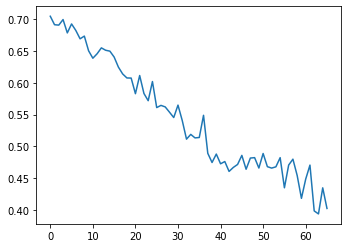

Train, it: 65 loss: 0.40
train loss:  0.42930060625076294


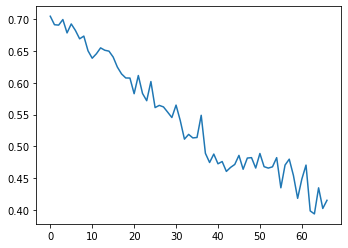

Train, it: 66 loss: 0.42
train loss:  0.4651413559913635


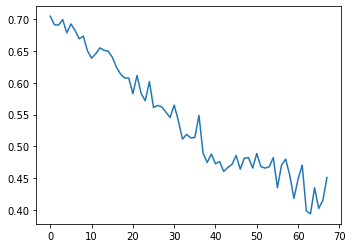

Train, it: 67 loss: 0.45
train loss:  0.3972567319869995


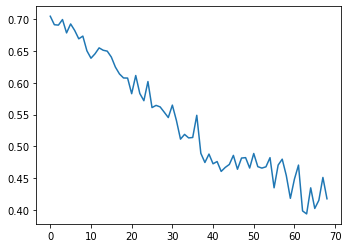

Train, it: 68 loss: 0.42
train loss:  0.4665781259536743


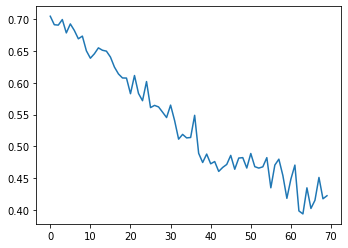

Train, it: 69 loss: 0.42
train loss:  0.4132104516029358


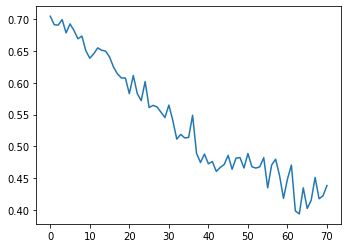

Train, it: 70 loss: 0.44
train loss:  0.359273761510849


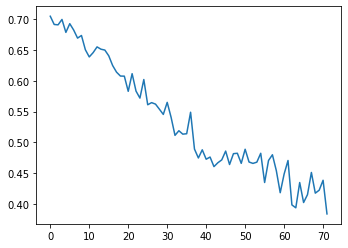

Train, it: 71 loss: 0.38
train loss:  0.42967489361763


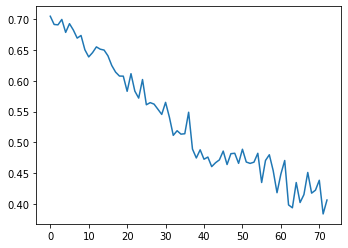

Train, it: 72 loss: 0.41
train loss:  0.39579930901527405


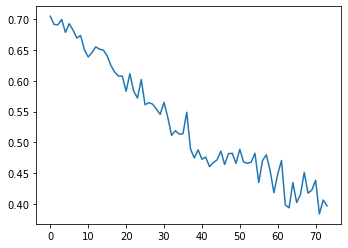

Train, it: 73 loss: 0.40
train loss:  0.4391702115535736


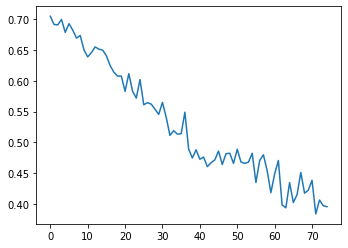

Train, it: 74 loss: 0.40
train loss:  0.4057358205318451


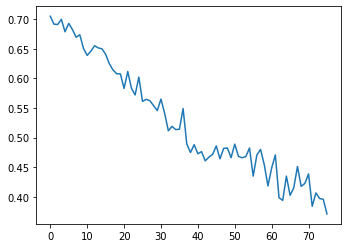

Train, it: 75 loss: 0.37
train loss:  0.34923553466796875


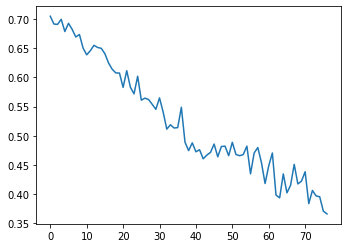

Train, it: 76 loss: 0.37
train loss:  0.3754357099533081


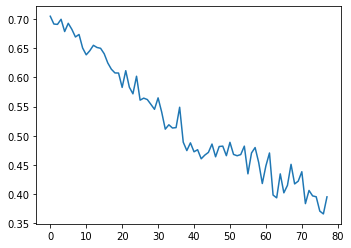

Train, it: 77 loss: 0.40
train loss:  0.39756378531455994


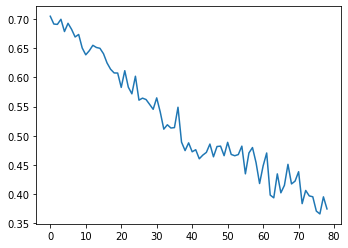

Train, it: 78 loss: 0.37
train loss:  0.4047127068042755


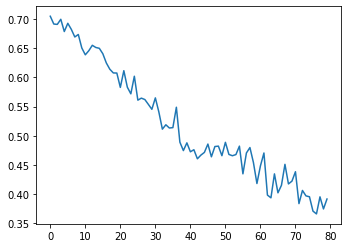

Train, it: 79 loss: 0.39
train loss:  0.3658965528011322


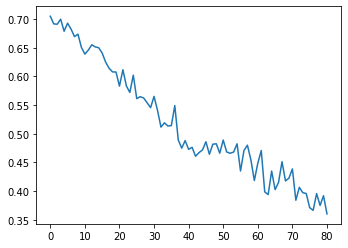

Train, it: 80 loss: 0.36
train loss:  0.3789084553718567


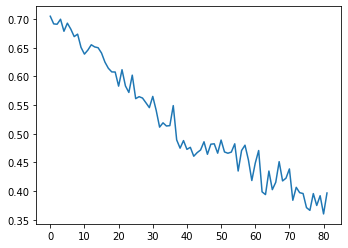

Train, it: 81 loss: 0.40
train loss:  0.36774352192878723


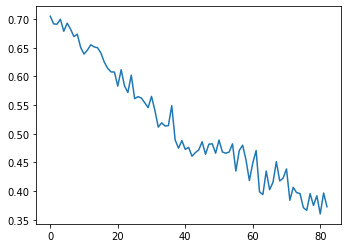

Train, it: 82 loss: 0.37
train loss:  0.3588721454143524


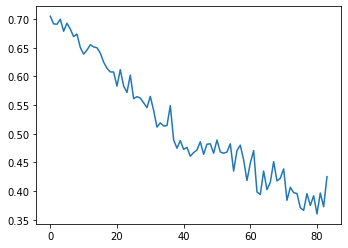

Train, it: 83 loss: 0.43
train loss:  0.3729347586631775


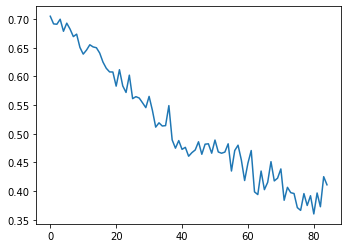

Train, it: 84 loss: 0.41
train loss:  0.34477806091308594


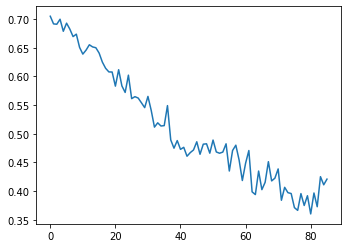

Train, it: 85 loss: 0.42
train loss:  0.46031615138053894


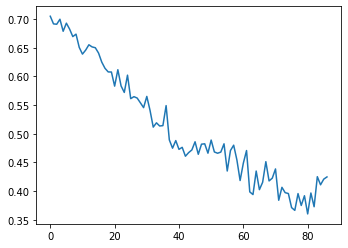

Train, it: 86 loss: 0.42
train loss:  0.4184802174568176


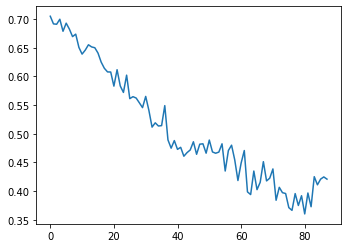

Train, it: 87 loss: 0.42
train loss:  0.4495135545730591


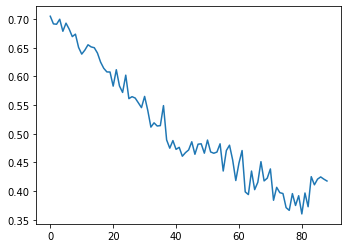

Train, it: 88 loss: 0.42
train loss:  0.43254274129867554


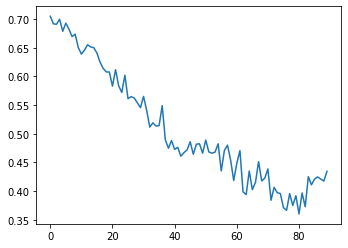

Train, it: 89 loss: 0.43
train loss:  0.3096068203449249


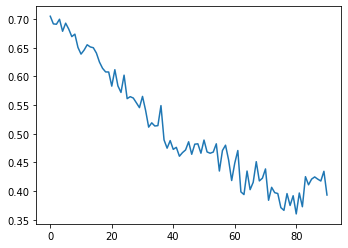

Train, it: 90 loss: 0.39
train loss:  0.4447267949581146


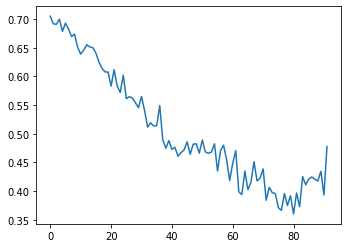

Train, it: 91 loss: 0.48
train loss:  0.41802099347114563


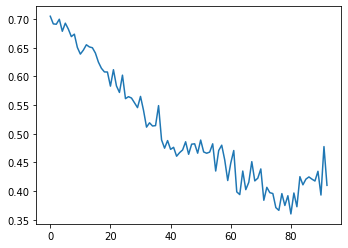

Train, it: 92 loss: 0.41
train loss:  0.4391246736049652


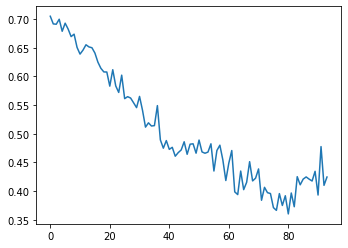

Train, it: 93 loss: 0.42
train loss:  0.4100116491317749


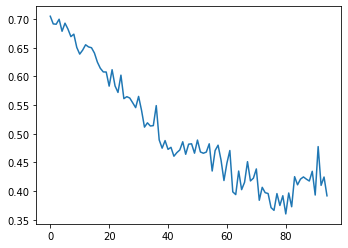

Train, it: 94 loss: 0.39
train loss:  0.3876880705356598


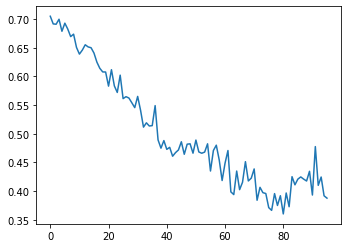

Train, it: 95 loss: 0.39
train loss:  0.46207815408706665


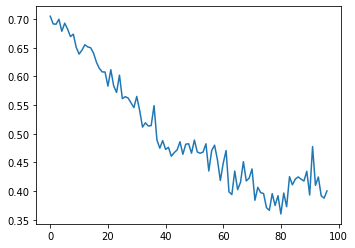

Train, it: 96 loss: 0.40
train loss:  0.4352961778640747


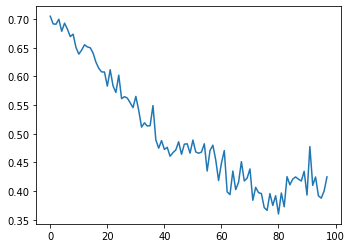

Train, it: 97 loss: 0.42
train loss:  0.42380058765411377


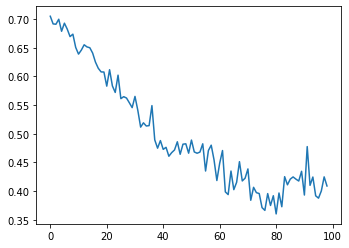

Train, it: 98 loss: 0.41
train loss:  0.3859204649925232


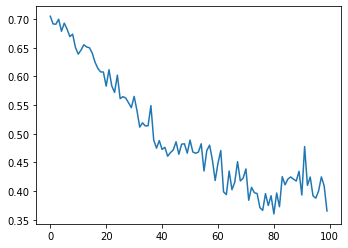

Train, it: 99 loss: 0.37
train loss:  0.4511086940765381


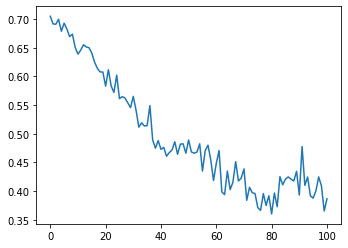

Train, it: 100 loss: 0.39
train loss:  0.3605377972126007


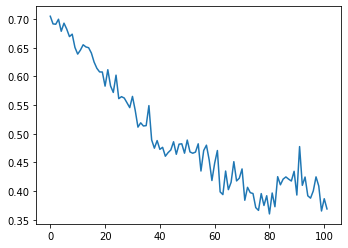

Train, it: 101 loss: 0.37
train loss:  0.33812057971954346


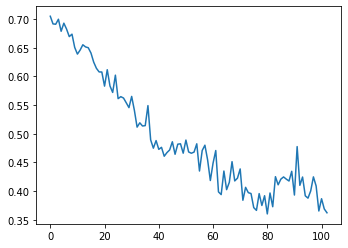

Train, it: 102 loss: 0.36
train loss:  0.3607541620731354


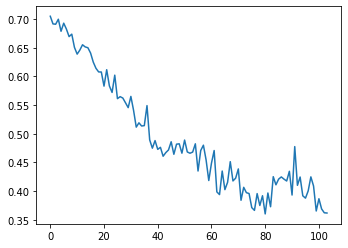

Train, it: 103 loss: 0.36
train loss:  0.4074866473674774


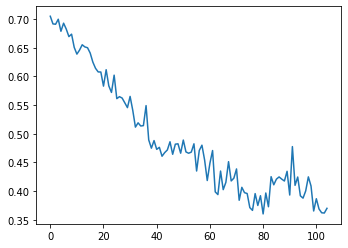

Train, it: 104 loss: 0.37
train loss:  0.33544376492500305


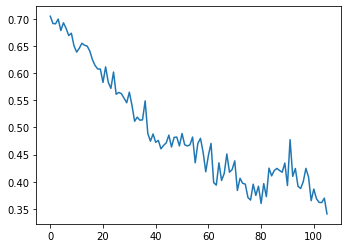

Train, it: 105 loss: 0.34
train loss:  0.40357378125190735


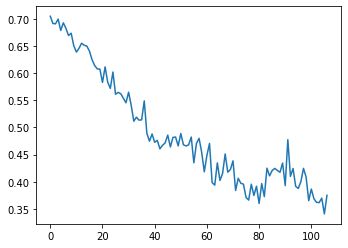

Train, it: 106 loss: 0.38
train loss:  0.3730789124965668


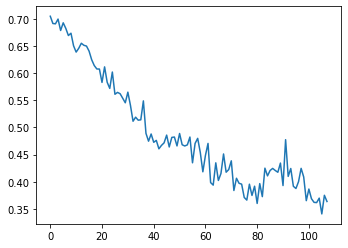

Train, it: 107 loss: 0.36
train loss:  0.3531695008277893


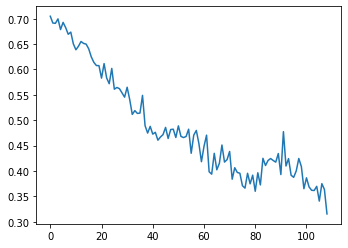

Train, it: 108 loss: 0.32
train loss:  0.390325665473938


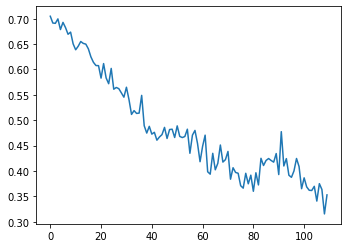

Train, it: 109 loss: 0.35
train loss:  0.4071052372455597


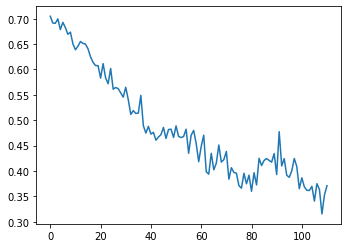

Train, it: 110 loss: 0.37
train loss:  0.3181520104408264


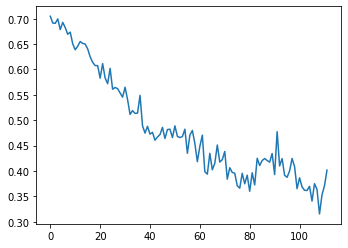

Train, it: 111 loss: 0.40
train loss:  0.31930744647979736


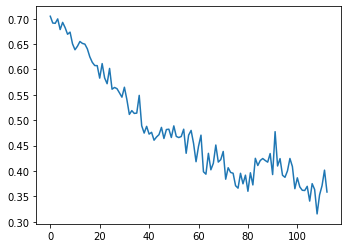

Train, it: 112 loss: 0.36
train loss:  0.28706711530685425


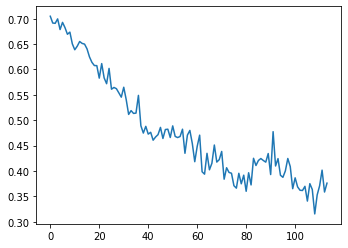

Train, it: 113 loss: 0.38
train loss:  0.3237679898738861


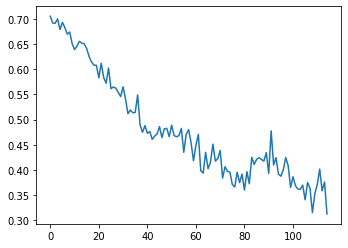

Train, it: 114 loss: 0.31
train loss:  0.34844890236854553


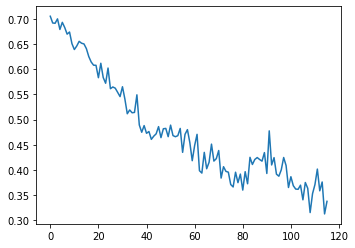

Train, it: 115 loss: 0.34
train loss:  0.30735620856285095


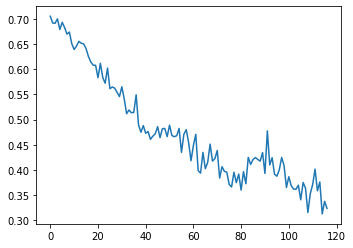

Train, it: 116 loss: 0.32
train loss:  0.3087943196296692


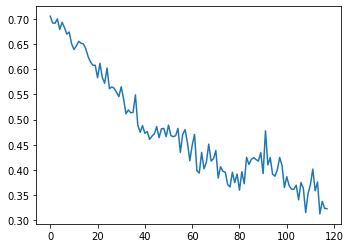

Train, it: 117 loss: 0.32
train loss:  0.36606284976005554


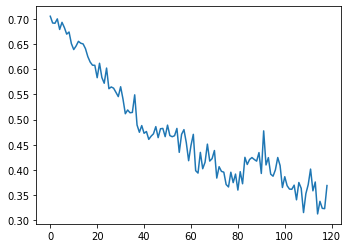

Train, it: 118 loss: 0.37
train loss:  0.3763561248779297


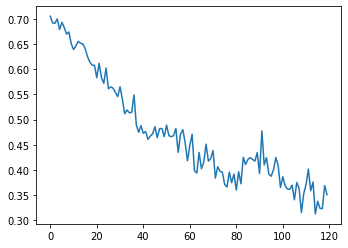

Train, it: 119 loss: 0.35
train loss:  0.33031532168388367


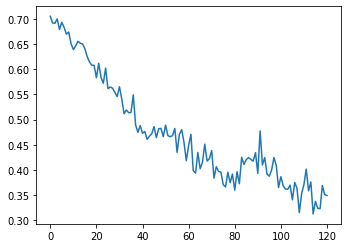

Train, it: 120 loss: 0.35
train loss:  0.31066983938217163


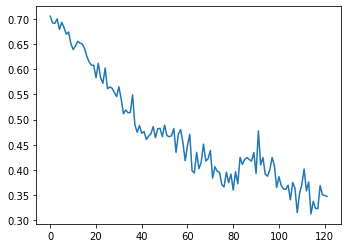

Train, it: 121 loss: 0.35
train loss:  0.3000667691230774


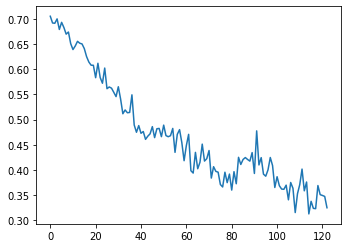

Train, it: 122 loss: 0.33
train loss:  0.45851394534111023


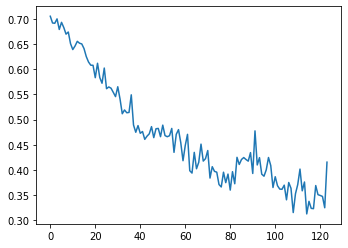

Train, it: 123 loss: 0.42
train loss:  0.3424670994281769


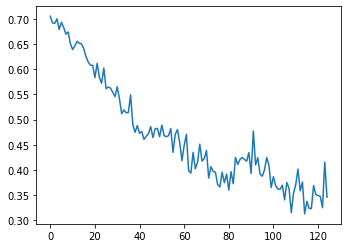

Train, it: 124 loss: 0.35
train loss:  0.3978819251060486


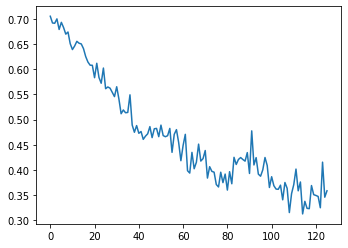

Train, it: 125 loss: 0.36
train loss:  0.28592631220817566


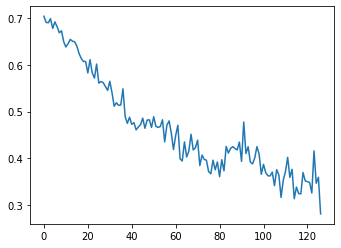

Train, it: 126 loss: 0.28
train loss:  0.34935829043388367


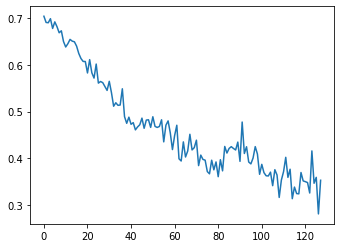

Train, it: 127 loss: 0.35
train loss:  0.3405989110469818


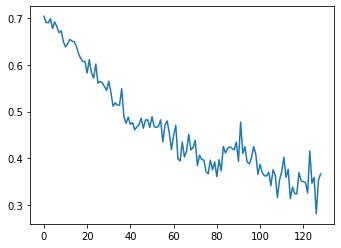

Train, it: 128 loss: 0.37
train loss:  0.3175099790096283


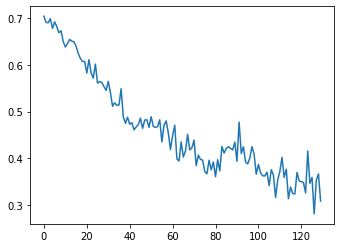

Train, it: 129 loss: 0.31
train loss:  0.3633287250995636


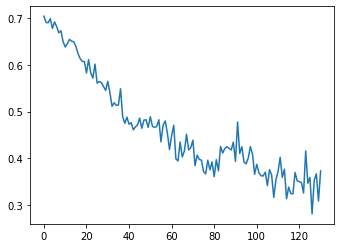

Train, it: 130 loss: 0.37
train loss:  0.38661375641822815


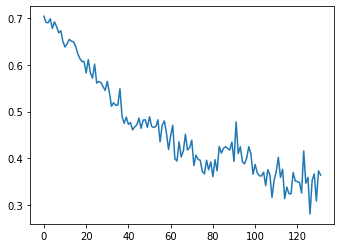

Train, it: 131 loss: 0.36
train loss:  0.466636598110199


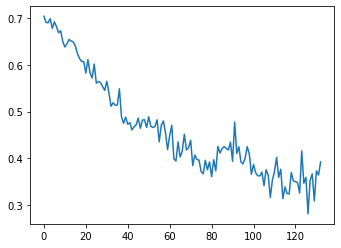

Train, it: 132 loss: 0.39
train loss:  0.3349582552909851


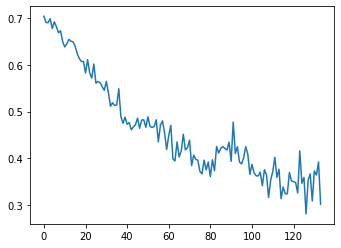

Train, it: 133 loss: 0.30
train loss:  0.3127487599849701


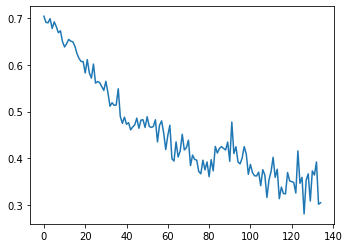

Train, it: 134 loss: 0.30
train loss:  0.3301868438720703


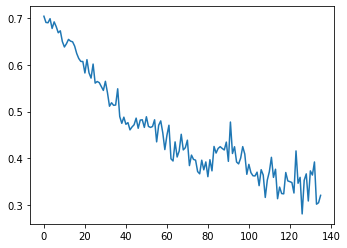

Train, it: 135 loss: 0.32
train loss:  0.37097644805908203


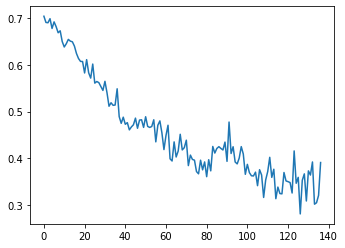

Train, it: 136 loss: 0.39
train loss:  0.38043147325515747


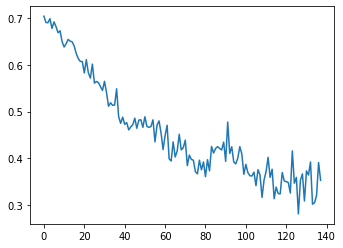

Train, it: 137 loss: 0.35
train loss:  0.3137195110321045


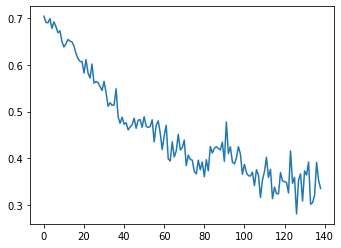

Train, it: 138 loss: 0.33
train loss:  0.32976165413856506


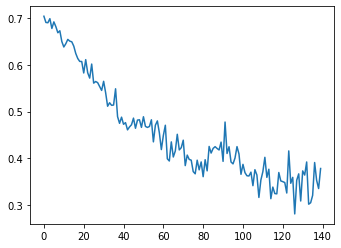

Train, it: 139 loss: 0.38
train loss:  0.32240211963653564


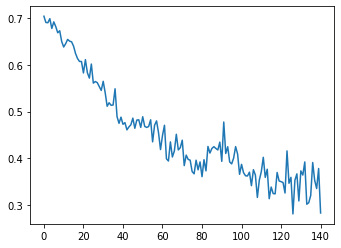

Train, it: 140 loss: 0.28
train loss:  0.3229916989803314


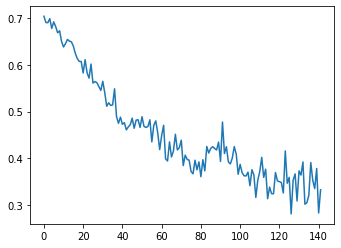

Train, it: 141 loss: 0.33
train loss:  0.3482619524002075


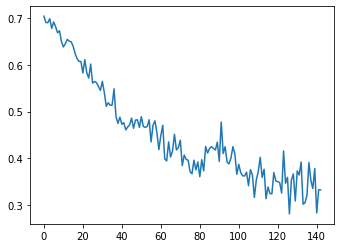

Train, it: 142 loss: 0.33
train loss:  0.34213271737098694


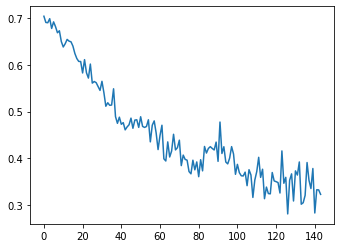

Train, it: 143 loss: 0.32
train loss:  0.39146435260772705


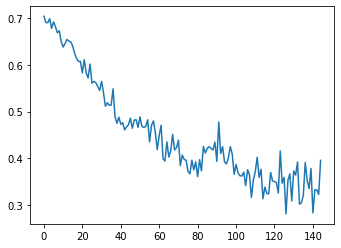

Train, it: 144 loss: 0.40
train loss:  0.3297000825405121


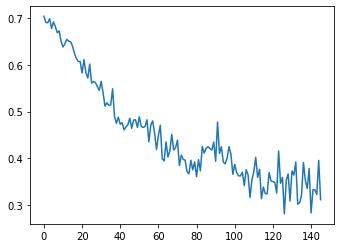

Train, it: 145 loss: 0.31
train loss:  0.30047163367271423


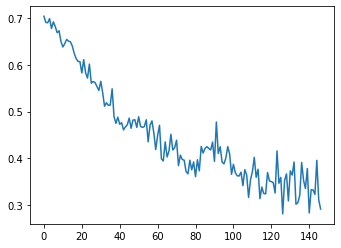

Train, it: 146 loss: 0.29
train loss:  0.34050002694129944


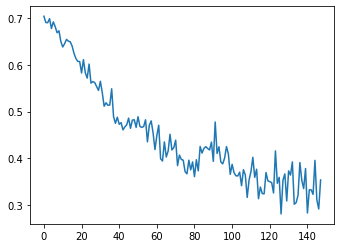

Train, it: 147 loss: 0.35
train loss:  0.3983139097690582


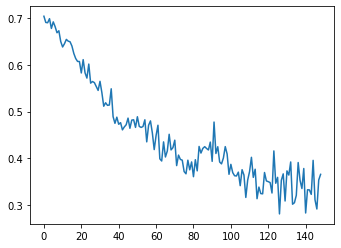

Train, it: 148 loss: 0.37
train loss:  0.30495360493659973


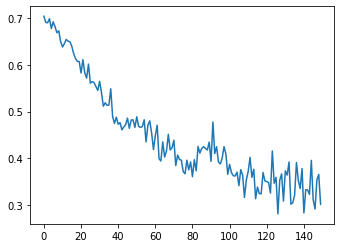

Train, it: 149 loss: 0.30
train loss:  0.40820878744125366


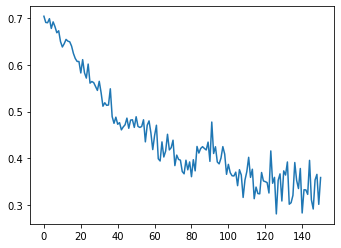

Train, it: 150 loss: 0.36
train loss:  0.32749274373054504


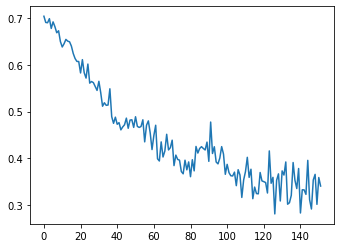

Train, it: 151 loss: 0.34
train loss:  0.3059629797935486


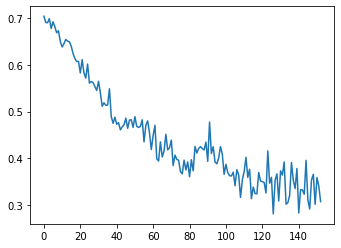

Train, it: 152 loss: 0.31
train loss:  0.3094245195388794


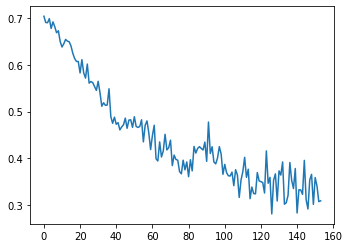

Train, it: 153 loss: 0.31
train loss:  0.28011083602905273


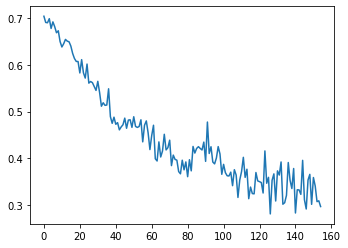

Train, it: 154 loss: 0.30
train loss:  0.28855276107788086


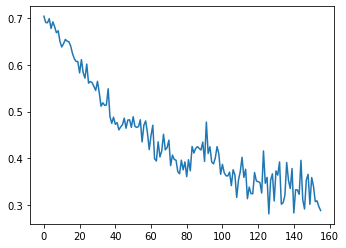

Train, it: 155 loss: 0.29
train loss:  0.30070263147354126


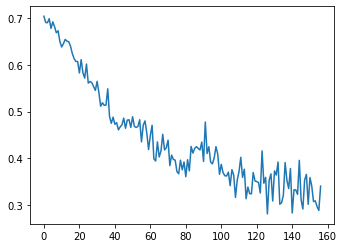

Train, it: 156 loss: 0.34
train loss:  0.3255499303340912


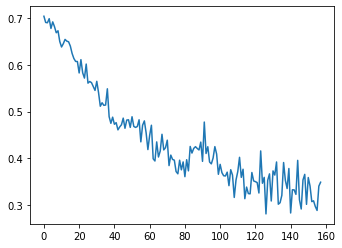

Train, it: 157 loss: 0.35
train loss:  0.26252710819244385


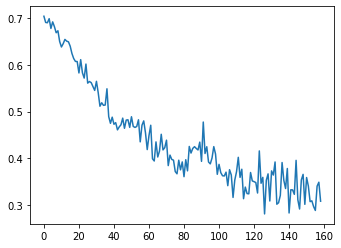

Train, it: 158 loss: 0.31
train loss:  0.3604300916194916


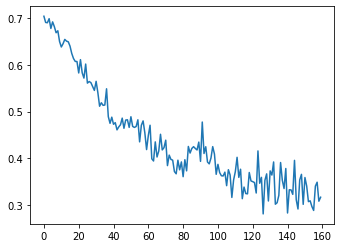

Train, it: 159 loss: 0.32
train loss:  0.3440788984298706


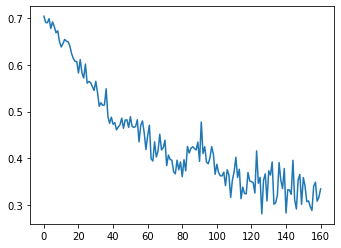

Train, it: 160 loss: 0.33
train loss:  0.35146018862724304


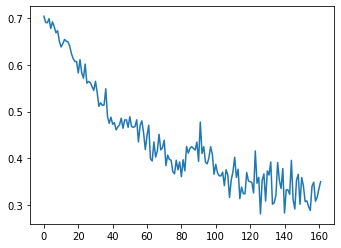

Train, it: 161 loss: 0.35
train loss:  0.3221829831600189


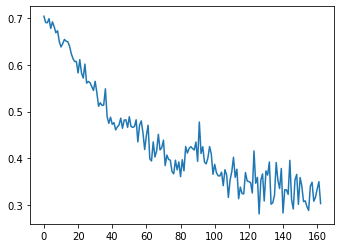

Train, it: 162 loss: 0.30
train loss:  0.27730080485343933


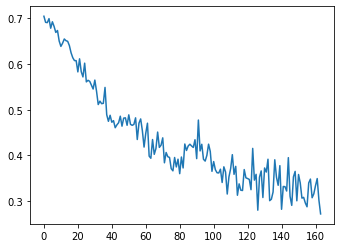

Train, it: 163 loss: 0.27
train loss:  0.2843860983848572


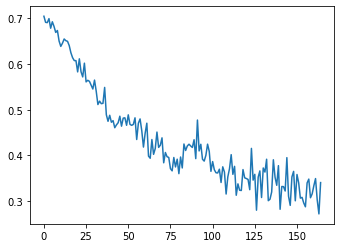

Train, it: 164 loss: 0.34
train loss:  0.34796142578125


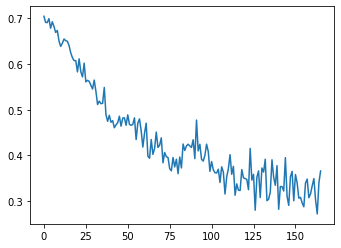

Train, it: 165 loss: 0.37
train loss:  0.34898436069488525


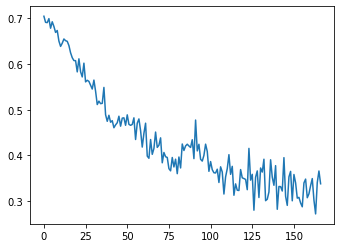

Train, it: 166 loss: 0.34
train loss:  0.35812416672706604


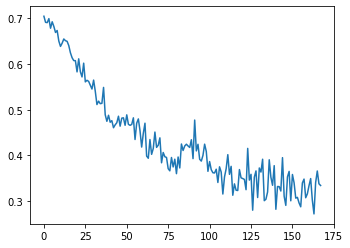

Train, it: 167 loss: 0.33
train loss:  0.2963258624076843


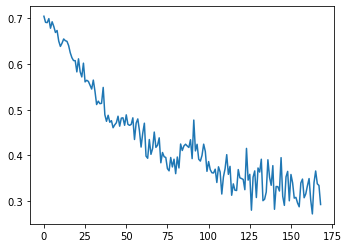

Train, it: 168 loss: 0.29
train loss:  0.30021727085113525


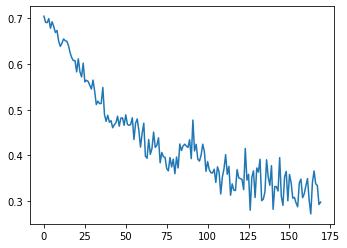

Train, it: 169 loss: 0.30
train loss:  0.29463204741477966


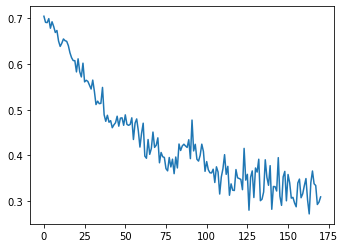

Train, it: 170 loss: 0.31
train loss:  0.2738453149795532


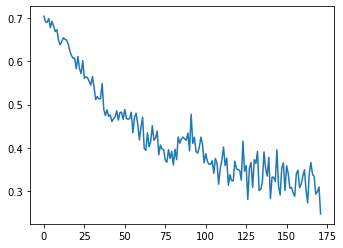

Train, it: 171 loss: 0.25
train loss:  0.26270443201065063


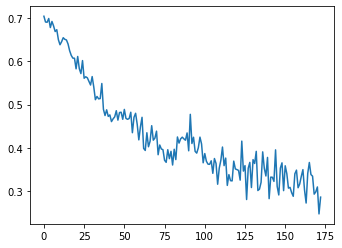

Train, it: 172 loss: 0.29
train loss:  0.26682940125465393


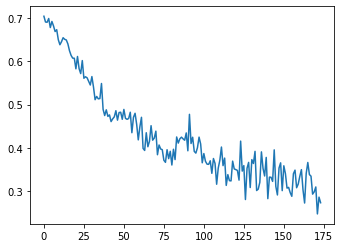

Train, it: 173 loss: 0.27
train loss:  0.284311980009079


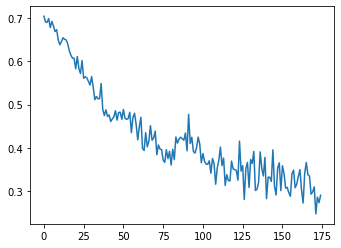

Train, it: 174 loss: 0.29
train loss:  0.28424718976020813


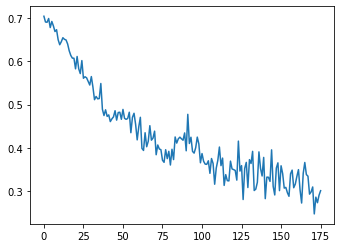

Train, it: 175 loss: 0.30
train loss:  0.35625097155570984


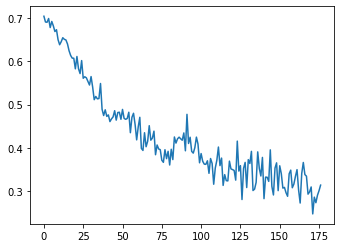

Train, it: 176 loss: 0.31
train loss:  0.299513041973114


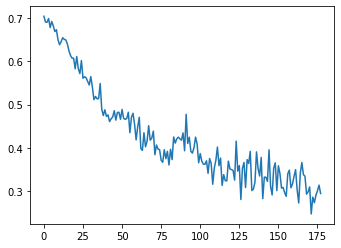

Train, it: 177 loss: 0.29
train loss:  0.2571074664592743


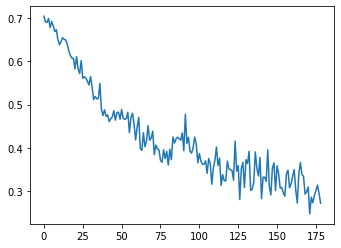

Train, it: 178 loss: 0.27
train loss:  0.2992597222328186


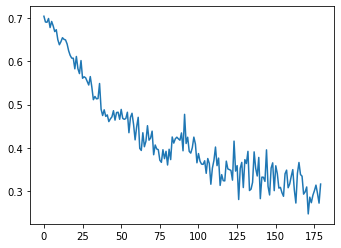

Train, it: 179 loss: 0.32
train loss:  0.34247928857803345


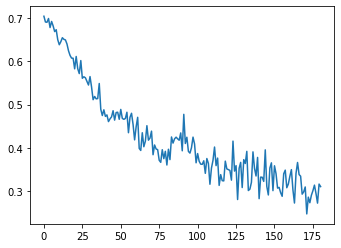

Train, it: 180 loss: 0.31
train loss:  0.2933502495288849


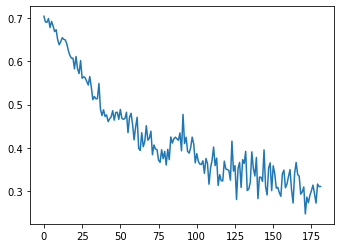

Train, it: 181 loss: 0.31
train loss:  0.34078529477119446


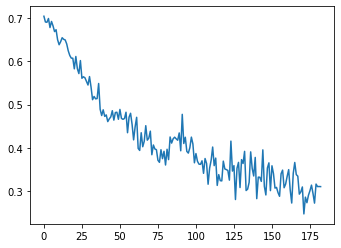

Train, it: 182 loss: 0.31
train loss:  0.31113100051879883


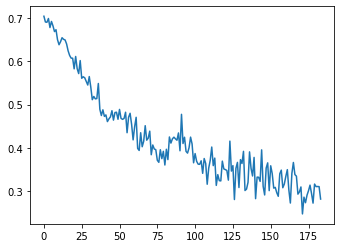

Train, it: 183 loss: 0.28
train loss:  0.2263367921113968


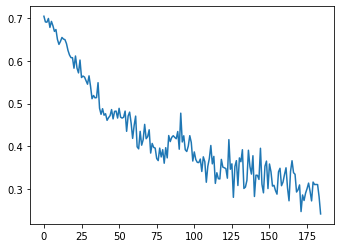

Train, it: 184 loss: 0.24
train loss:  0.27585700154304504


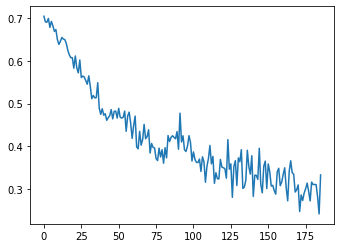

Train, it: 185 loss: 0.33
train loss:  0.3120099902153015


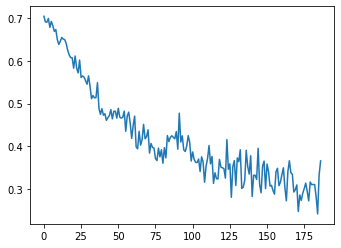

Train, it: 186 loss: 0.37
train loss:  0.3927345275878906


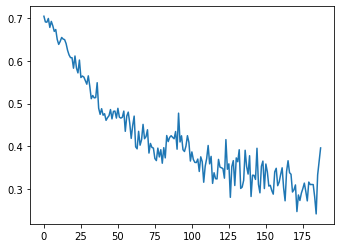

Train, it: 187 loss: 0.40
train loss:  0.2533518373966217


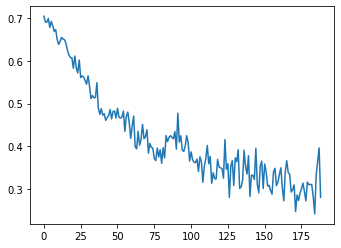

Train, it: 188 loss: 0.28
train loss:  0.34297671914100647


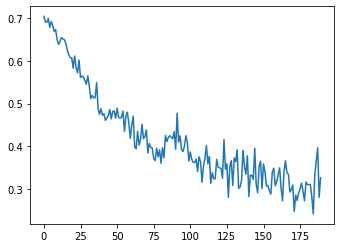

Train, it: 189 loss: 0.33
train loss:  0.2823553681373596


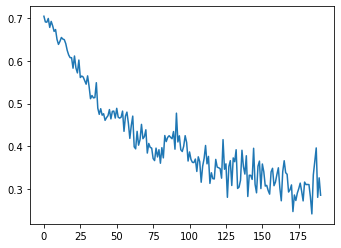

Train, it: 190 loss: 0.29
train loss:  0.2995895445346832


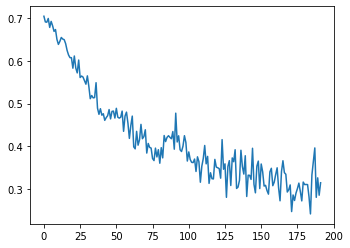

Train, it: 191 loss: 0.31
train loss:  0.29397276043891907


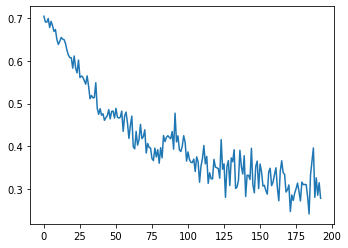

Train, it: 192 loss: 0.28
train loss:  0.2788692116737366


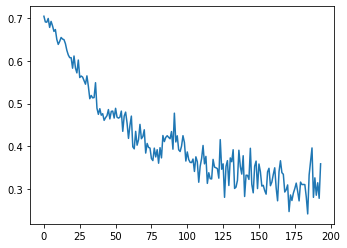

Train, it: 193 loss: 0.36
train loss:  0.2649811804294586


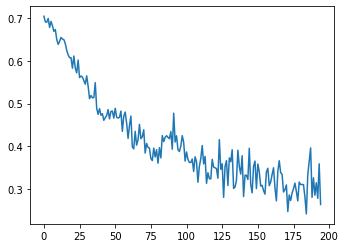

Train, it: 194 loss: 0.26
train loss:  0.24738776683807373


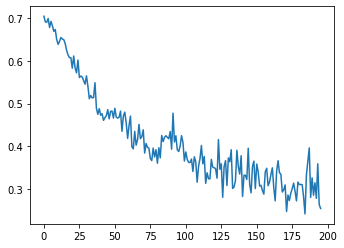

Train, it: 195 loss: 0.25
train loss:  0.33081865310668945


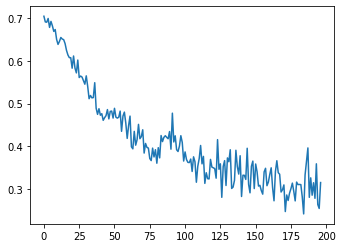

Train, it: 196 loss: 0.31
train loss:  0.2667984962463379


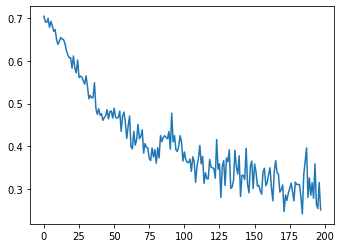

Train, it: 197 loss: 0.25
train loss:  0.27416542172431946


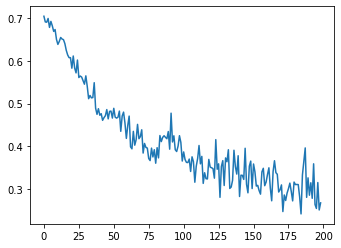

Train, it: 198 loss: 0.27
train loss:  0.26851585507392883


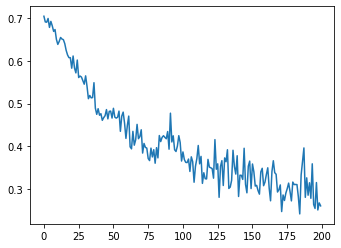

Train, it: 199 loss: 0.26
train loss:  0.3270286023616791


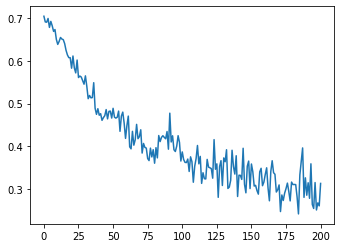

Train, it: 200 loss: 0.31
train loss:  0.25940975546836853


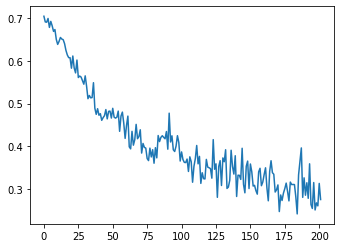

Train, it: 201 loss: 0.27
train loss:  0.30164679884910583


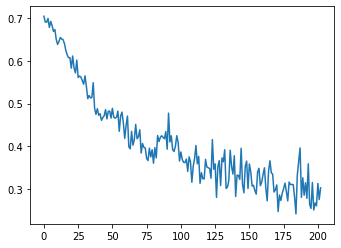

Train, it: 202 loss: 0.30
train loss:  0.28515681624412537


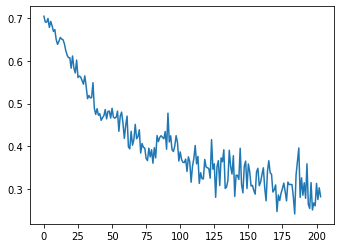

Train, it: 203 loss: 0.28
train loss:  0.3305429518222809


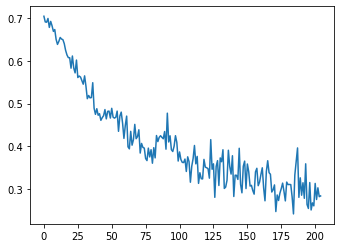

Train, it: 204 loss: 0.28
train loss:  0.2840307652950287


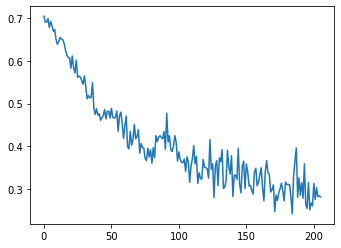

Train, it: 205 loss: 0.28
train loss:  0.29168152809143066


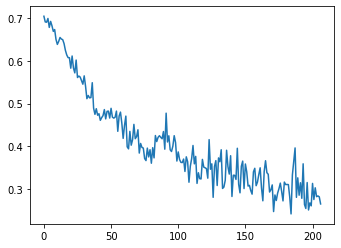

Train, it: 206 loss: 0.26
train loss:  0.2500990331172943


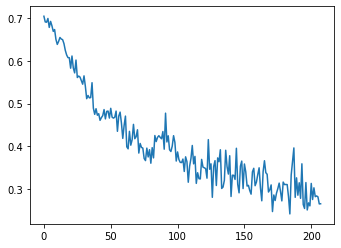

Train, it: 207 loss: 0.27
train loss:  0.2483435422182083


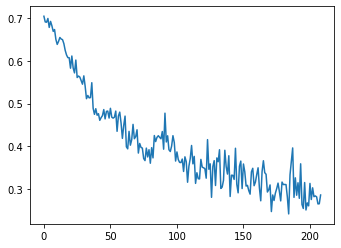

Train, it: 208 loss: 0.29
train loss:  0.3104408085346222


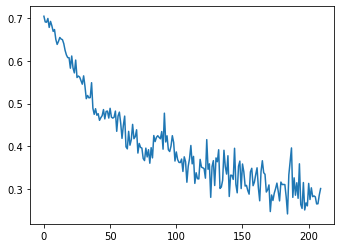

Train, it: 209 loss: 0.30
train loss:  0.24768993258476257


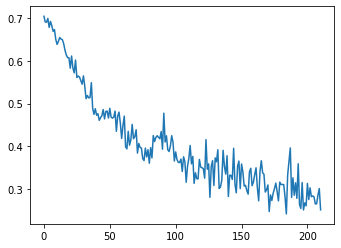

Train, it: 210 loss: 0.25
train loss:  0.2833973169326782


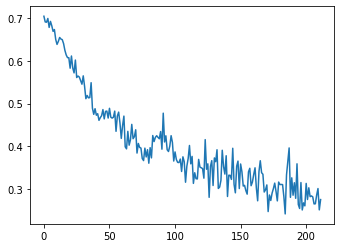

Train, it: 211 loss: 0.27
train loss:  0.25300636887550354


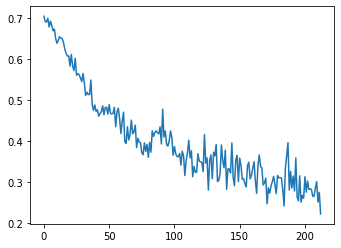

Train, it: 212 loss: 0.22
train loss:  0.2487243413925171


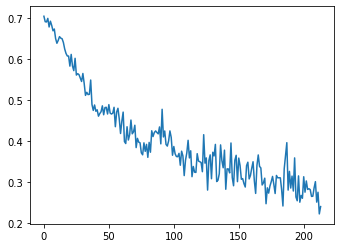

Train, it: 213 loss: 0.24
train loss:  0.23773664236068726


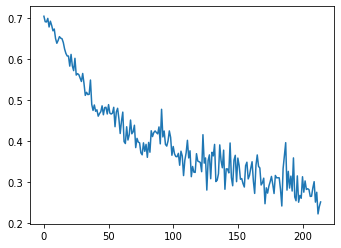

Train, it: 214 loss: 0.25
train loss:  0.25519421696662903


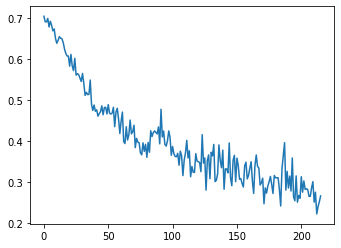

Train, it: 215 loss: 0.27
train loss:  0.22352218627929688


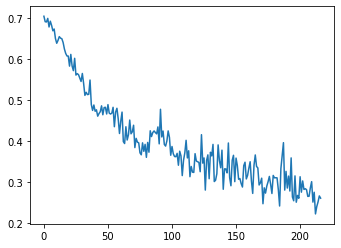

Train, it: 216 loss: 0.26
train loss:  0.22341741621494293


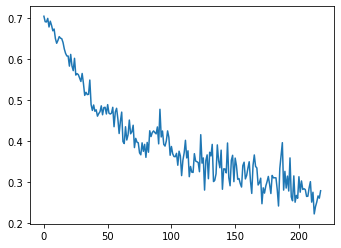

Train, it: 217 loss: 0.28
train loss:  0.26951825618743896


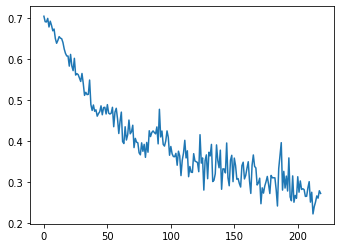

Train, it: 218 loss: 0.27
train loss:  0.24128229916095734


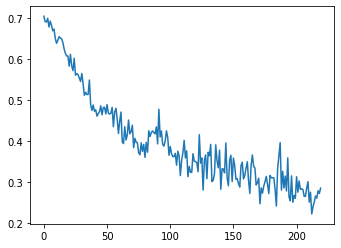

Train, it: 219 loss: 0.28
train loss:  0.2647421658039093


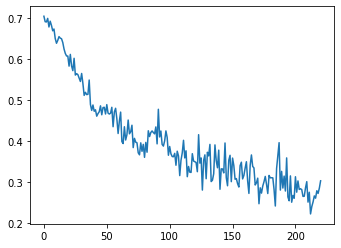

Train, it: 220 loss: 0.30
train loss:  0.2584286332130432


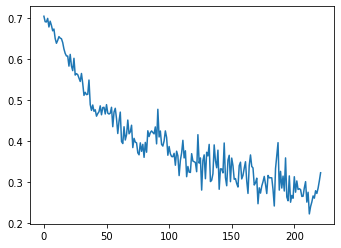

Train, it: 221 loss: 0.32
train loss:  0.2399025708436966


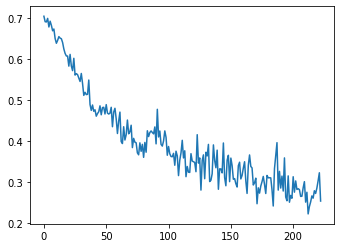

Train, it: 222 loss: 0.25
train loss:  0.2584923803806305


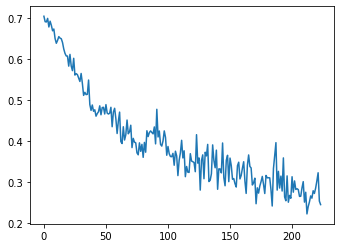

Train, it: 223 loss: 0.24
train loss:  0.29445692896842957


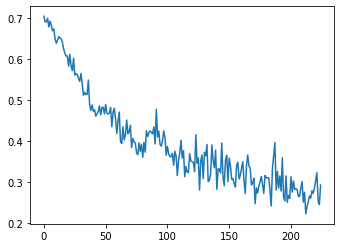

Train, it: 224 loss: 0.29
train loss:  0.2505018413066864


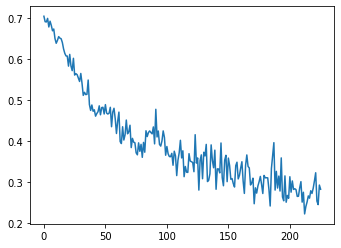

Train, it: 225 loss: 0.28
train loss:  0.2508798837661743


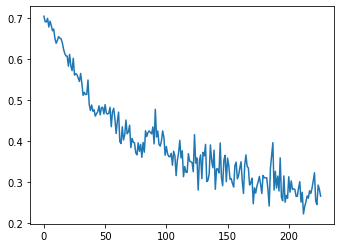

Train, it: 226 loss: 0.27
train loss:  0.28598886728286743


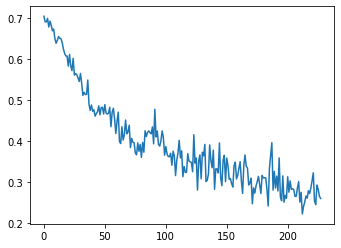

Train, it: 227 loss: 0.26
train loss:  0.26758286356925964


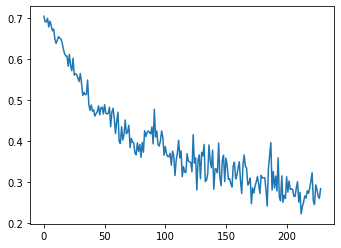

Train, it: 228 loss: 0.28
train loss:  0.22049756348133087


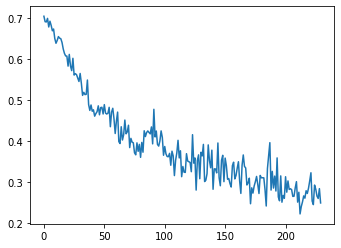

Train, it: 229 loss: 0.25
train loss:  0.28999778628349304


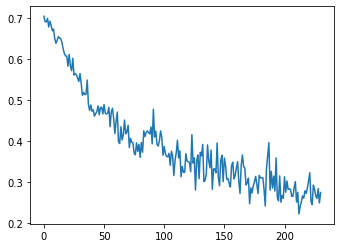

Train, it: 230 loss: 0.27
train loss:  0.22834785282611847


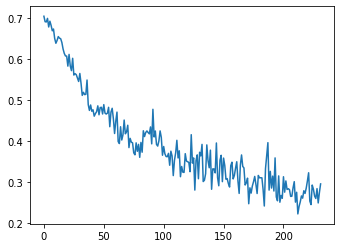

Train, it: 231 loss: 0.30
train loss:  0.3048795461654663


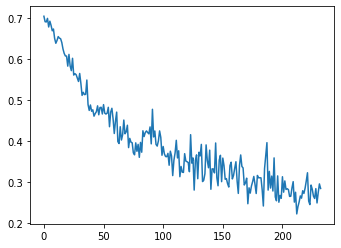

Train, it: 232 loss: 0.28
train loss:  0.29672473669052124


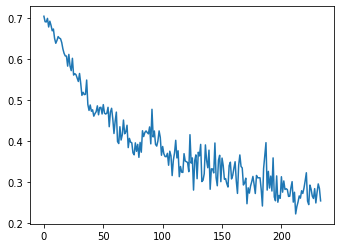

Train, it: 233 loss: 0.25
train loss:  0.21659348905086517


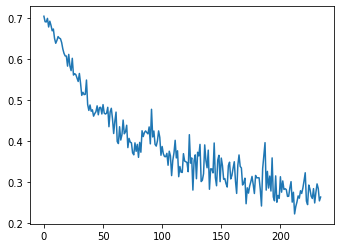

Train, it: 234 loss: 0.26
train loss:  0.3117455840110779


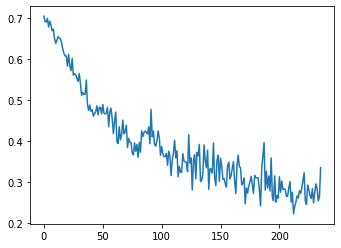

Train, it: 235 loss: 0.34
train loss:  0.3766167461872101


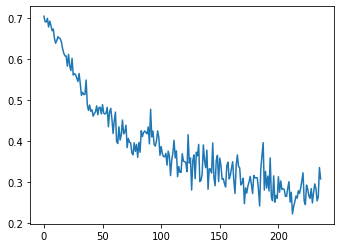

Train, it: 236 loss: 0.31
train loss:  0.255693644285202


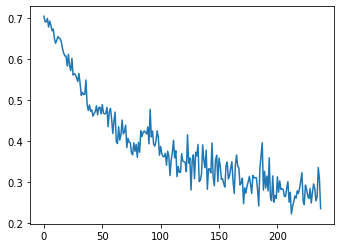

Train, it: 237 loss: 0.23
train loss:  0.31072351336479187


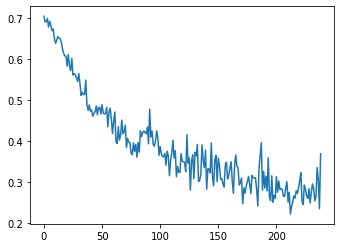

Train, it: 238 loss: 0.37
train loss:  0.23992429673671722


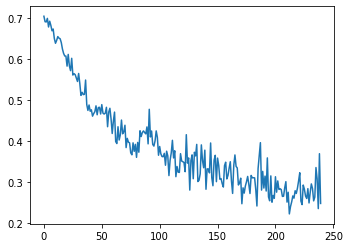

Train, it: 239 loss: 0.25
train loss:  0.23041711747646332


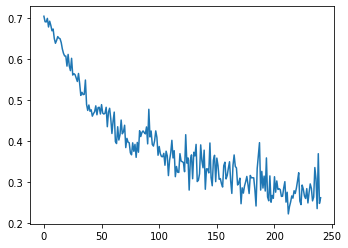

Train, it: 240 loss: 0.26
train loss:  0.3642525374889374


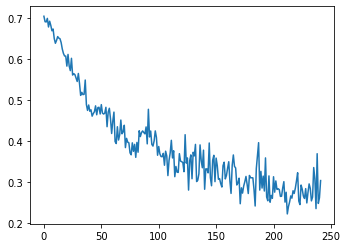

Train, it: 241 loss: 0.30
train loss:  0.3727341890335083


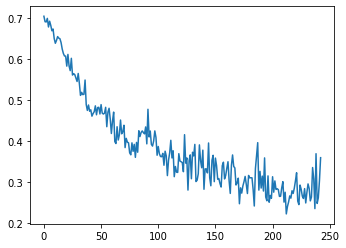

Train, it: 242 loss: 0.36
train loss:  0.24734912812709808


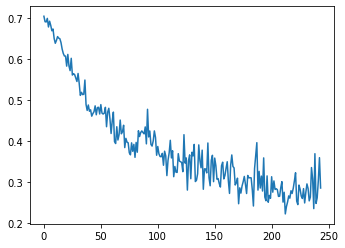

Train, it: 243 loss: 0.29
train loss:  0.2598278820514679


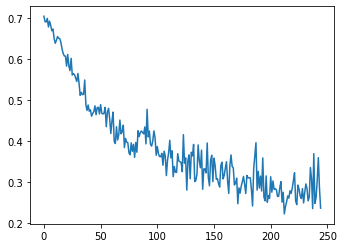

Train, it: 244 loss: 0.24
train loss:  0.2851218283176422


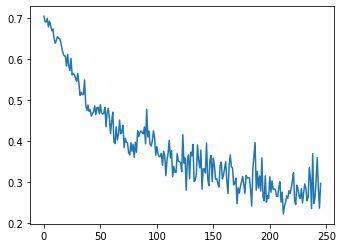

Train, it: 245 loss: 0.30
train loss:  0.28977832198143005


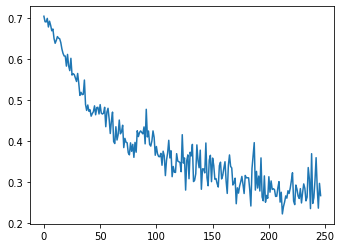

Train, it: 246 loss: 0.27
train loss:  0.29451704025268555


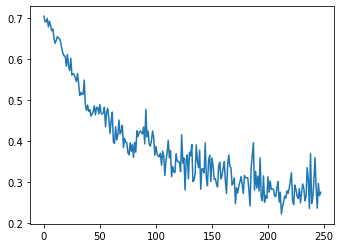

Train, it: 247 loss: 0.27
train loss:  0.23800647258758545


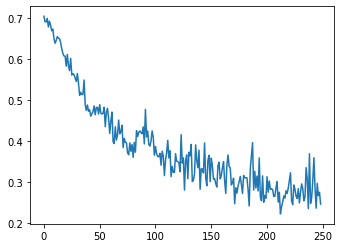

Train, it: 248 loss: 0.25
train loss:  0.2822238802909851


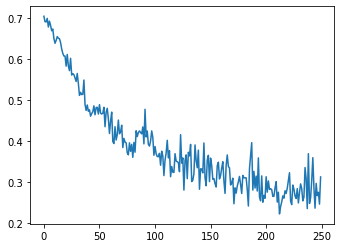

Train, it: 249 loss: 0.31
train loss:  0.3222811818122864


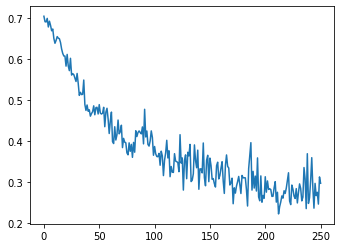

Train, it: 250 loss: 0.30
train loss:  0.2759638726711273


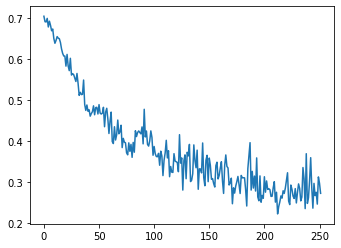

Train, it: 251 loss: 0.27
train loss:  0.296150267124176


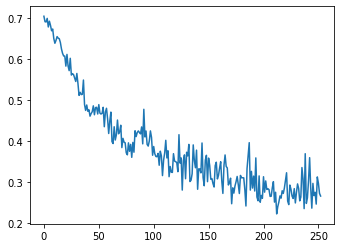

Train, it: 252 loss: 0.27
train loss:  0.31908267736434937


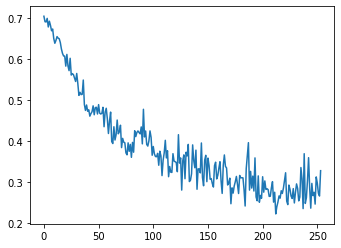

Train, it: 253 loss: 0.33
train loss:  0.28238826990127563


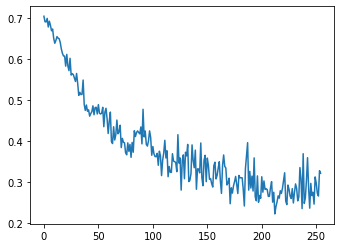

Train, it: 254 loss: 0.32
train loss:  0.2553313672542572


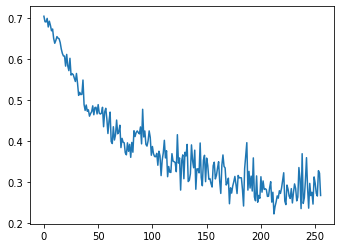

Train, it: 255 loss: 0.27
train loss:  0.26282191276550293


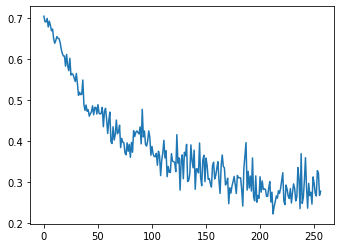

Train, it: 256 loss: 0.28
train loss:  0.313302218914032


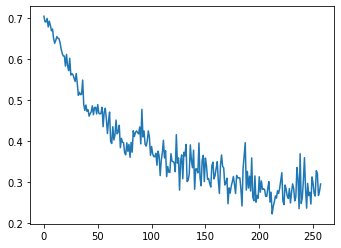

Train, it: 257 loss: 0.29
train loss:  0.2729017734527588


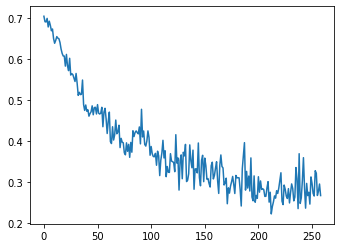

Train, it: 258 loss: 0.27
train loss:  0.2649948000907898


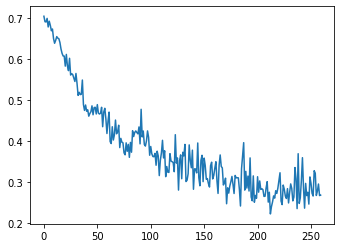

Train, it: 259 loss: 0.27
train loss:  0.2591598927974701


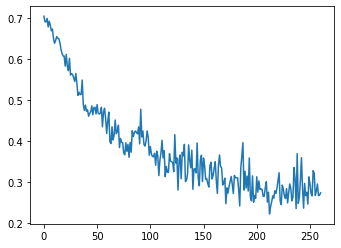

Train, it: 260 loss: 0.27
train loss:  0.23452822864055634


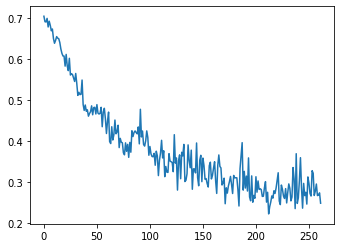

Train, it: 261 loss: 0.25
train loss:  0.30958834290504456


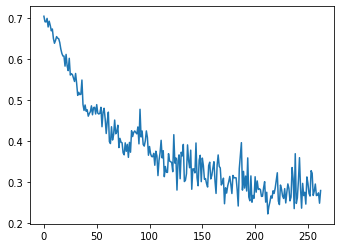

Train, it: 262 loss: 0.28
train loss:  0.2342783361673355


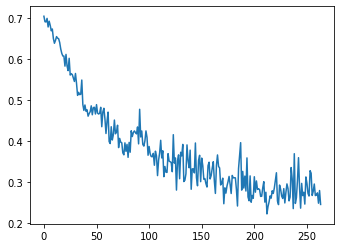

Train, it: 263 loss: 0.25
train loss:  0.274983674287796


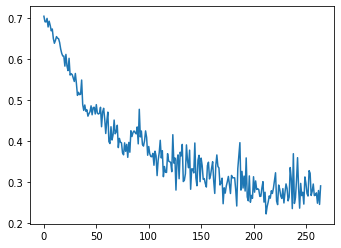

Train, it: 264 loss: 0.29
train loss:  0.2633780539035797


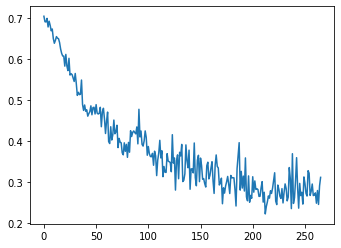

Train, it: 265 loss: 0.31
train loss:  0.24933181703090668


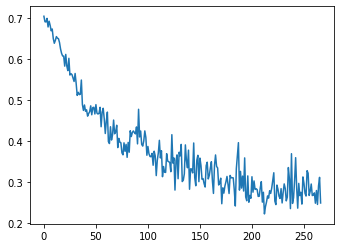

Train, it: 266 loss: 0.25
train loss:  0.28665295243263245


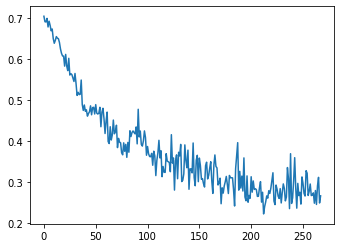

Train, it: 267 loss: 0.27
train loss:  0.32833412289619446


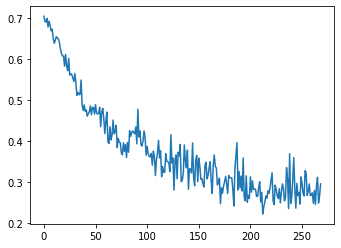

Train, it: 268 loss: 0.30
train loss:  0.2248792201280594


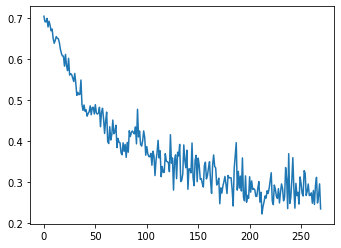

Train, it: 269 loss: 0.23
train loss:  0.2802383303642273


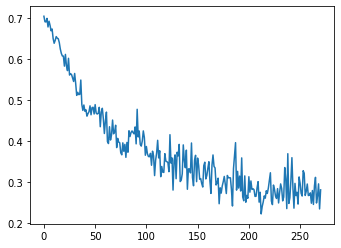

Train, it: 270 loss: 0.28
train loss:  0.30169478058815


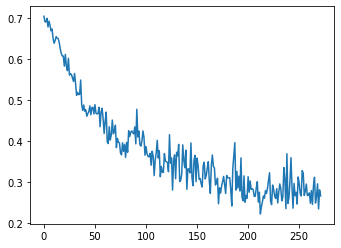

Train, it: 271 loss: 0.27
train loss:  0.290334016084671


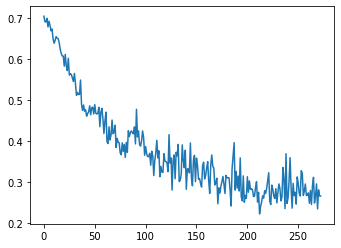

Train, it: 272 loss: 0.27
train loss:  0.24626193940639496


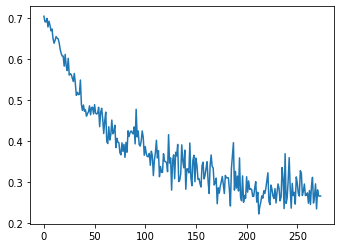

Train, it: 273 loss: 0.27
train loss:  0.30267682671546936


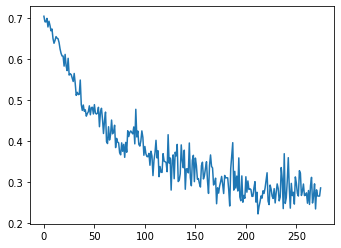

Train, it: 274 loss: 0.29
train loss:  0.2097548246383667


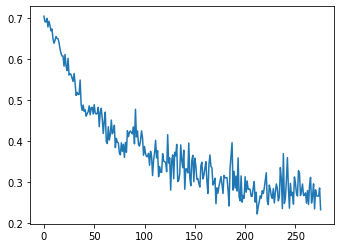

Train, it: 275 loss: 0.23
train loss:  0.20150098204612732


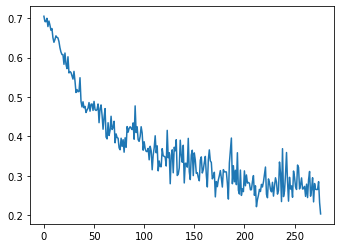

Train, it: 276 loss: 0.20
train loss:  0.2586907744407654


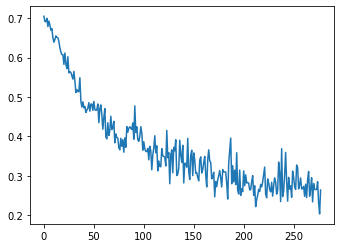

Train, it: 277 loss: 0.26
train loss:  0.20457251369953156


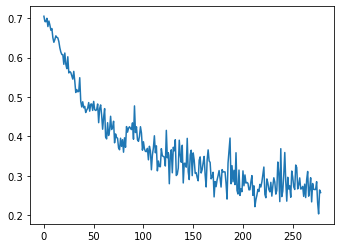

Train, it: 278 loss: 0.26
train loss:  0.3037503659725189


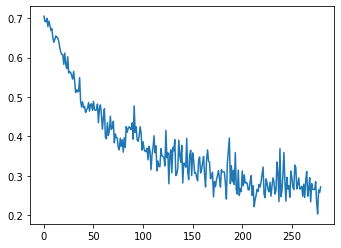

Train, it: 279 loss: 0.27
train loss:  0.27682703733444214


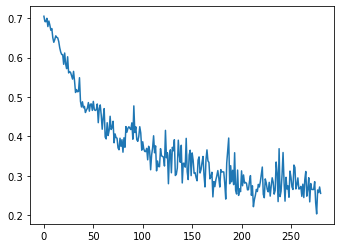

Train, it: 280 loss: 0.26
train loss:  0.3052090108394623


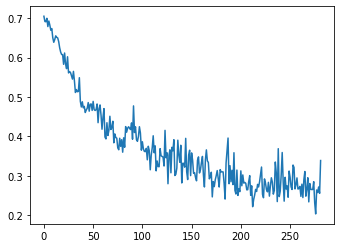

Train, it: 281 loss: 0.34
train loss:  0.2577017545700073


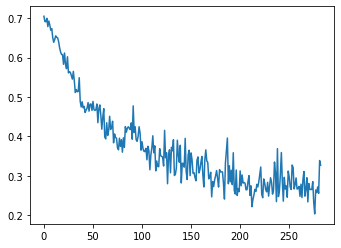

Train, it: 282 loss: 0.33
train loss:  0.27797362208366394


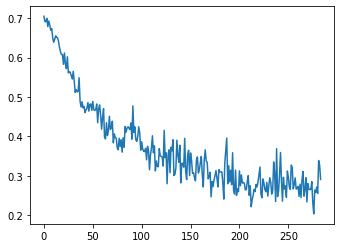

Train, it: 283 loss: 0.29
train loss:  0.2393825650215149


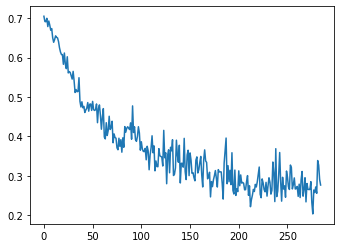

Train, it: 284 loss: 0.28
train loss:  0.3225879967212677


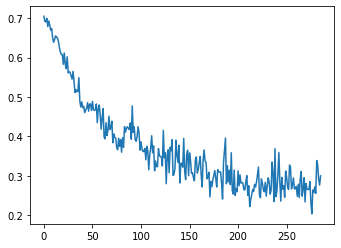

Train, it: 285 loss: 0.30
train loss:  0.24628661572933197


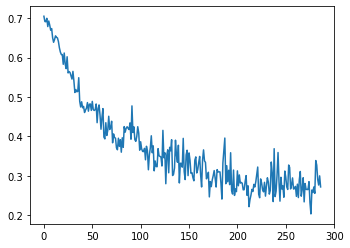

Train, it: 286 loss: 0.27
train loss:  0.35452109575271606


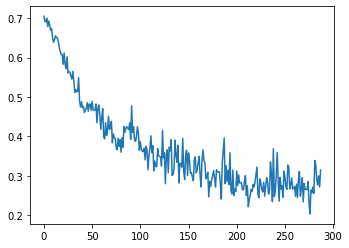

Train, it: 287 loss: 0.31
train loss:  0.2961007356643677


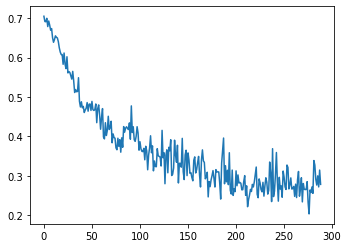

Train, it: 288 loss: 0.28
train loss:  0.22565783560276031


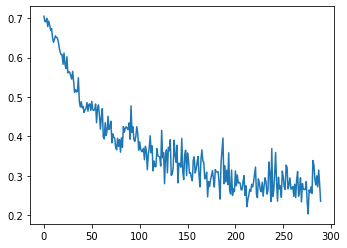

Train, it: 289 loss: 0.24
train loss:  0.24292899668216705


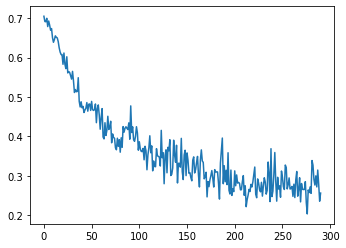

Train, it: 290 loss: 0.26
train loss:  0.24371589720249176


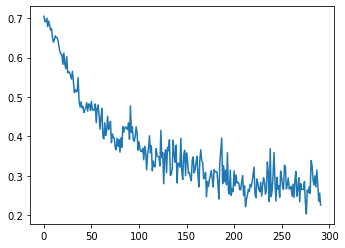

Train, it: 291 loss: 0.23
train loss:  0.24883735179901123


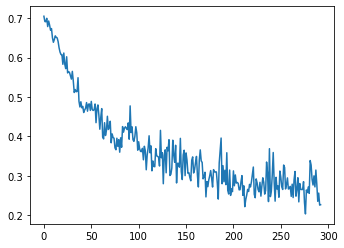

Train, it: 292 loss: 0.23
train loss:  0.25168710947036743


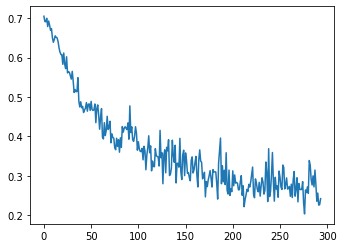

Train, it: 293 loss: 0.24
train loss:  0.31301987171173096


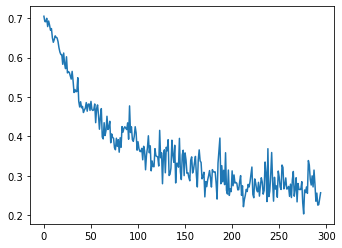

Train, it: 294 loss: 0.26
train loss:  0.2621299624443054


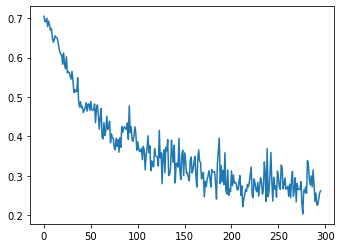

Train, it: 295 loss: 0.26
train loss:  0.19574591517448425


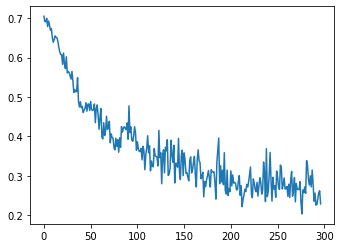

Train, it: 296 loss: 0.23
train loss:  0.2471093088388443


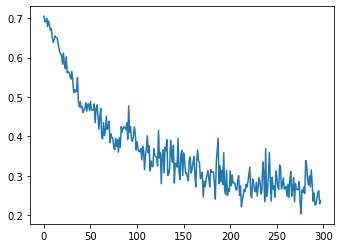

Train, it: 297 loss: 0.24
train loss:  0.26303598284721375


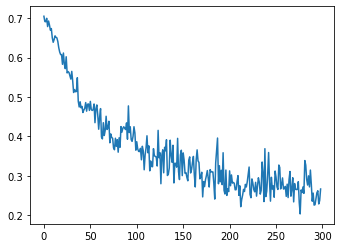

Train, it: 298 loss: 0.27
train loss:  0.24320712685585022


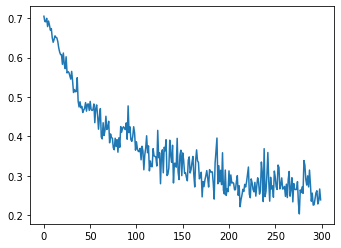

Train, it: 299 loss: 0.24


In [48]:
max_iter = 300
log_every = 100
eval_every = 100

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Train network
net.train()
for i in range(max_iter):
    train_iter.append(i)
    cur_loss = 0
    batch_iter = 0
    for j, batch_train in enumerate(dataloader_train):
        # Train
        inputs = get_variable(Variable(batch_train['image']))
        anno = get_variable(Variable(batch_train['annotation']))
        output = net(inputs)
        batch_loss = criterion(output, anno)

        cur_loss += float(get_numpy(batch_loss))
        batch_iter = j + 1
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        if j % 5 == 0:
            print("train loss: ", cur_loss / (j+1))

    # scheduler.step()
    cur_loss /= batch_iter
    train_loss.append(cur_loss)
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.plot(train_iter, train_loss, label='train_loss')
    plt.show()
    # clear_output(wait=True)

    print("Train, it: {} loss: {:.2f}".format(i, train_loss[-1]))


input shape: torch.Size([1, 3, 522, 775])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


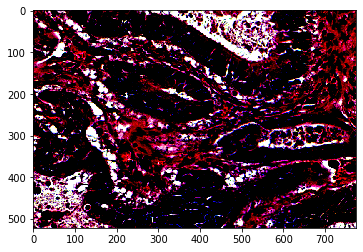

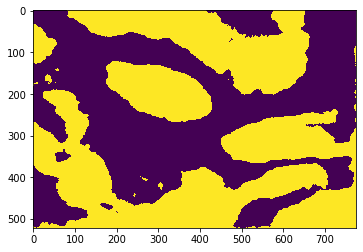

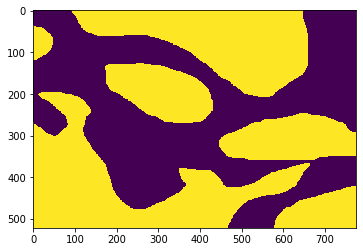

In [51]:
for batch_data in dataloader_observe:
    fig_img = plt.figure()
    inputs = get_variable(Variable(batch_data['image']))
    anno = batch_data['annotation']
    output = net(inputs)
    print('input shape:', inputs.shape)
    plt.imshow(get_numpy(inputs[0].permute(1, 2, 0)))
    plt.show()
    fig_img.suptitle('image')
    out1 = get_numpy(output[0][0])
    out1[out1>0] = 1
    out1[out1<0] = 0
    plt.imshow(out1)
    # plt.show()
    # out2 = get_numpy(output[0][1])
    # out2[out2>0] = 0
    # out2[out2<0] = 1
    # plt.imshow(out2)
    plt.show()
    plt.imshow(anno[0][0])
    plt.show()
    break

In [52]:
anno = get_variable(Variable(anno))
loss = criterion(output, anno)
print(get_numpy(loss))

0.2843064
